# Position Reconstruction for XeBRA - LRF - Measurements Analysis

**Status:** August 2019

Position reconstruction for XeBRA following the position reconstruction algorithm of Mercury (employed in the LUX experiment, originally developed for the ZEPLIN-III dark matter experiment) with light response functions (see https://arxiv.org/abs/1710.02752v2 and https://arxiv.org/abs/1112.1481 ).

In [1]:
#### Imports:

import sys
import glob

import numpy as np
from numpy import exp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import pandas as pd
import math

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence

## General Definitions and Parameters

In [2]:
#### General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
#### Fixed input parameters

## PMT properties
R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.
PMT_ID = np.array([1,2,3,4,5,6,7])
PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates
PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})

## Radius S2 region used to constrain radius reconstructed position
p_TPC_radius = 35

## Fit parameters LRFs
## MC driven (R_PTFE = 95 %, T_meshes = 89.770509 %, lambda_LXe = 100 cm); 
## To be iteratively determined from data later
fit_parameters_eta_v1 = np.array([[ 0.76784314,  0.04281434,  0.00264452, -0.16502946],
       [ 0.86618744, -0.04220011,  0.00349323, -0.21111826],
       [ 0.76836278,  0.0427951 ,  0.00265082, -0.16546435],
       [ 0.76766095, -0.04280319,  0.00264167, -0.16492769],
       [ 0.86537262, -0.04224966,  0.00347602, -0.20996557],
       [ 0.76728103,  0.04285181,  0.00263252, -0.16423993],
       [-0.02781789,  1.27335415, -0.01554958,  0.56522927]])
fit_parameters_eta_v2 = np.array([[  0.5862075 ,  30.03753042,  -0.34682365,   4.18897093,  2.59854272],
       [  0.6389123 ,  29.31198247,  -0.3388027 ,   4.04470674,  2.63577199],
       [  0.58620791,  29.9885029 ,  -0.34004891,   4.17451146,  2.60269506],
       [  0.58610133,  30.01226409,  -0.33813655,   4.17468471,  2.59997022],
       [  0.6394532 ,  29.50418414,  -0.37196722,   4.10965579,  2.62267883],
       [  0.58654552,  30.13917691,  -0.36157398,   4.22025887,  2.59104887],
       [  0.53325685,  39.60254022, -18.11911918,  20.76666722,  2.24994645]])
fit_parameters_eta_v3 = np.array([[14.98906971,  6.01402517,  0.6260277 ,  0.03175688],
       [15.0328818 ,  5.88840721,  0.67446688,  0.03821948],
       [14.99645946,  6.01064072,  0.62595618,  0.03176641],
       [14.99212962,  6.01742089,  0.62604177,  0.03172401],
       [15.00980035,  5.90048797,  0.67550156,  0.03817195],
       [14.96863869,  6.02563842,  0.62689395,  0.03171014],
       [14.42475061,  4.6118038 ,  0.46425292,  0.09923257]])
fit_parameters_eta_v4 = np.array([[ 1.50458218e+01,  5.24536009e+00,  5.56365828e-01,  7.80021868e-02, -8.70727228e-04],
       [ 1.50495274e+01,  5.12846441e+00,  5.96407767e-01,  9.21654167e-02, -1.05651169e-03],
       [ 1.50530290e+01,  5.24107977e+00,  5.56230036e-01,  7.80704244e-02, -8.71867254e-04],
       [ 1.50492943e+01,  5.24533429e+00,  5.56099760e-01,  7.81532305e-02, -8.74082128e-04],
       [ 1.50294150e+01,  5.14635567e+00,  5.97943157e-01,  9.16457735e-02, -1.04685791e-03],
       [ 1.50284661e+01,  5.25817388e+00,  5.57305438e-01,  7.77962504e-02, -8.67398231e-04],
       [ 1.45326430e+01,  5.59447419e+00,  6.41420473e-01,  -5.34046071e-02,  4.27492085e-03]])

## Imports and Data Processing

In [4]:
## Selection of file to be analyzed:
#filename = '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_3.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root'
#filename_list = ['/media/alex/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04.root']
filename_list = glob.glob("/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_1.0e+05_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04_*.root")
#filename_list = ['/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/optPhot_S2_3.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse.root']

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
 
# filename prefix for automatically naming outputs

if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]
    
elif filename[6:25] == 'Simulation_Data/Mod':
    filenameprefix = filename[:-5][44:]
    
elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]
    
elif filename[:45] == '/media/ab602/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][45:]
    
elif filename[:63] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][63:]
    
elif filename[:70] == '/media/ab602/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][70:]
    
elif filename[:44] == '/media/alex/TOSHIBA EXT/Simulation_Data/LCE/':
    filenameprefix = filename[:-5][44:]
    
elif filename[:62] == '/media/alex/TOSHIBA EXT/Simulation_Data/Modification_Spacer_3/':
    filenameprefix = filename[:-5][62:]
    
elif filename[:69] == '/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/':
    filenameprefix = filename[:-5][69:]

else:
    filenameprefix = 'filenameprefix'
    
filenameprefix = 'MCfakemeasurement_' + filenameprefix

In [5]:
print(filenameprefix)

MCfakemeasurement_optPhot_S2_1.0e+06_pmtGap4.5_RPTFE0.95_LXeAbs100_Tmesh0.89770509_writeEmptyFalse_nop_1.0e+04


In [6]:
## Import as pandas dataframes

import uproot
import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    print('.', end = '')
print('\n')
    
if filenameprefix.find('nop') > 0:
    nop_string = filenameprefix[(filenameprefix.find('nop')+4) : (filenameprefix.find('+', filenameprefix.find('nop')+4)+3)]
    exec('nop = '+nop_string)
    print('nop = '+str(nop))
    _chunk_collect['nbpmthits'] = _chunk_collect['nbpmthits'] / nop
    _chunk_collect['ntpmthits'] = _chunk_collect['ntpmthits'] / nop
    _chunk_collect['pmthits'] = _chunk_collect['pmthits'] / nop
else:
    print('Error: Number of particles per event = 1!')
    
## Separate hits for individual PMTs
## Takes a while to calculate...
for i in range(0,8):
    _chunk_collect['pmthits_'+str(i)] = pd.Series(nth_tuple_subentries(np.asarray(_chunk_collect['pmthits']), i), index=_chunk_collect.index)
    print(i, end=' ')
    
## Total PMT hits
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)

/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


..........

nop = 10000.0
0 1 2 3 4 5 6 7 

In [7]:
HF_list = np.array([np.array(_chunk_collect['pmthits_1'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_2'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_3'])/np.array(_chunk_collect['ntpmthits']),
                    np.array(_chunk_collect['pmthits_4'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_5'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_6'])/np.array(_chunk_collect['ntpmthits']), 
                    np.array(_chunk_collect['pmthits_7'])/np.array(_chunk_collect['ntpmthits'])])
HF_list = HF_list[:,0:10000] # reduce statistics
#HF_list = HF_list.T
HF_list.shape

(7, 10000)

## Reconstruction Algorithm

In [8]:
#### Definition and selection of radial LRF model

## Position Reconstruction in LUX, https://arxiv.org/abs/1710.02752v2
def eta_v1(r, A, gamma, m, b):
    return A / (1 + gamma ** 2 * r ** 2) ** (3/2) + m * r + b

## Position Reconstruction in a Dual Phase Xenon Scintillation Detector, https://arxiv.org/abs/1112.1481
def eta_v2(r, A, r0, a, b, alpha):
    return A * exp( - a * (r/r0) / (1 + (r/r0) ** (1 - alpha)) - b / (1 + (r/r0) ** (- alpha)))   

## Modified Woods Saxon Potential
def eta_v3(r, R, a, V0, d):
    return V0 / (1 + np.exp((r - R) / a)) + d

## Modified Woods Saxon Potential + Linear
def eta_v4(r, R, a, V0, d, m):
    return V0 / (1 + np.exp((r - R) / a)) + d + m * r

## Choice for LRF model
model = eta_v2                  # default:  eta_v2
modelstring = 'eta_v2'          # default: 'eta_v2'

In [9]:
#### Definition of metric q to be minimized

## Function q to minimize for position reconstruction 
## Choose from: 'ChiSquared' 'LogLikelihoodRatio' 'WeightedChiSquared'
minimizer = 'ChiSquared'        # default: 'ChiSquared'

## Normalize LRFs to sum LRFs for all PMTs
normalization_to_sum = True     # default: True

## Ignore PMTs (i.e. set HF and LRF to 0) with light share below a specific threshold
cut_LS_PMT = False              # default: False

if cut_LS_PMT == True:
    cut_LS_PMT_threshold = 0.04 # start playing around with 0.04 - 0.05

## Mask to exclude PMTs not passing cut_LS_PMT_threshold
def pass_cut_LS_PMT_threshold(HFs_input):
    if cut_LS_PMT == True:
        return (HFs_input >= cut_LS_PMT_threshold).astype(int)
    if cut_LS_PMT == False:
        return (np.array([1]*7))

## LRF values for above conditions

if normalization_to_sum == False: ## radial LRFs only
    modelstring_save = modelstring
    def LRF_PMTi(x, y, PMT, fitparameters):
        fp = fitparameters[PMT-1]
        return model(np.sqrt((x - PMT_positions['PMT_position_x'][PMT])**2 + (y - PMT_positions['PMT_position_y'][PMT])**2), *fp)
    def LRF_PMTs(x, y, HFs_input, fitparameters):
        return np.array([LRF_PMTi(x, y, j, fitparameters) for j in range(1,8)])*pass_cut_LS_PMT_threshold(HFs_input)
    
if normalization_to_sum == True: ## radial LRFs normalized to sum radial LRFs
    modelstring_save = modelstring+'_overSum'
    def LRF_PMTi(x, y, PMT, fitparameters):
        fp = fitparameters[PMT-1]
        return model(np.sqrt((x - PMT_positions['PMT_position_x'][PMT])**2 + (y - PMT_positions['PMT_position_y'][PMT])**2), *fp)
    def LRF_PMTs(x, y, HFs_input, fitparameters):
        LRF_PMTs_array = np.array([LRF_PMTi(x, y, j, fitparameters) for j in range(1,8)])*pass_cut_LS_PMT_threshold(HFs_input)
        LRF_PMTs_array_uncut = np.array([LRF_PMTi(x, y, j, fitparameters) for j in range(1,8)])
        return LRF_PMTs_array / (np.sum(LRF_PMTs_array_uncut))

## Unweighted Chi squared from LRFs:

if minimizer == 'ChiSquared':
    modelstring_save = modelstring_save+'_Chi2'
    
    ## numerator [top of the fraction]
    def numerator(x, y, HFs_input, fitparameters):
        return (LRF_PMTs(x, y, HFs_input, fitparameters) - HFs_input*pass_cut_LS_PMT_threshold(HFs_input))**2
    
    ## denominator [bottom of a fraction]
    def denominator(x, y, fitparameters):
        return LRF_PMTs(x, y, (np.array([1]*7)), fitparameters)
    
    ## Chi²
    def q(x, y, HFs_input, fitparameters):
        return np.sum(numerator(x, y, HFs_input, fitparameters) / denominator(x, y, fitparameters))

## Weighted Chi squared from LRFs:
    
if minimizer == 'WeightedChiSquared':
    modelstring_save = modelstring_save+'_WChi2'
    sigma = 1./3. # excess noise factor for each PMT, default: 1/3
    
    ## numerator [top of the fraction]
    def numerator(x, y, HFs_input, fitparameters):
        return (LRF_PMTs(x, y, HFs_input, fitparameters) - HFs_input*pass_cut_LS_PMT_threshold(HFs_input))**2
    
    ## denominator [bottom of a fraction]
    def denominator(x, y, fitparameters):
        return LRF_PMTs(x, y, (np.array([1]*7)), fitparameters) * (1 + sigma**2)
    
    ## Chi²
    def q(x, y, HFs_input, fitparameters):
        return np.sum(numerator(x, y, HFs_input, fitparameters) / denominator(x, y, fitparameters))

## Log Likelihood Ratio from LRFs:    

if minimizer == 'LogLikelihoodRatio':
    modelstring_save = modelstring_save+'_LLR'
    
    def q(x, y, HFs_input, fitparameters):
        summed = 0
        for i in range(0,7):
            if pass_cut_LS_PMT_threshold(HFs_input)[i] > 0:
                summed += 2 * (LRF_PMTs(x, y, HFs_input, fitparameters)[i] - HFs_input[i]*pass_cut_LS_PMT_threshold(HFs_input)[i] + HFs_input[i]*pass_cut_LS_PMT_threshold(HFs_input)[i] * np.log( (HFs_input[i]*pass_cut_LS_PMT_threshold(HFs_input)[i]) / (LRF_PMTs(x, y, HFs_input, fitparameters)[i]) ))
        return summed

In [10]:
#### Reconstruct position inside volume

## Function to return non-negative value corresponding to (radial position - radius TPC) if inside TPC,
## used for constraints

def insidevolume(inputs):
    return (p_TPC_radius - np.sqrt(inputs[0]**2 + inputs[1]**2))

## Reconstruct position by minimizing q

def reconstructed(HFs_input, fitparameters):
    reconstruct = lambda x: q(x[0], x[1], HFs_input, fitparameters) # The objective function to be minimized.
    x0 = [0.001,0.001] # Initial guess.
    bnds = ((-35, 35), (-35, 35)) # Bounds on variables for L-BFGS-B, TNC, SLSQP and trust-constr methods.
    meth = 'SLSQP' # Type of solver. 'BFGS' / 'L-BFGS-B' / 'SLSQP' / ...
    cons = ({'type': 'ineq', "fun": insidevolume}) # Constraints definition (only for COBYLA, SLSQP and trust-constr).
    ################################
    # The optimization result represented as a OptimizeResult object:
    #res = minimize(reconstruct, x0, method = meth)
    #res = minimize(reconstruct, x0, bounds = bnds)
    res = minimize(reconstruct, x0, method=meth, constraints=cons)
    return res

## Iterative Reconstruction

In [11]:
#### General settings

## Maximum number of iterations
iterations = 5

## Fiducial radial cuts in mm
rfiducial = 20          # fiducial cut on radial position in TPC, default: 20
rfiducial_under = 15    # fiducial cut on radial distance from center individual PMT, default: 15

## Fiducial radial cut central PMT in mm 
rfiducial_central = 32  # fiducial cut on radial position in TPC, default: 34 / 30

## Fiducial radial cut 0th iteration in mm
rfiducial0 = 20         # default: 34
rfiducial0_under = 15   # default: -1, set to -1 to make inactive
rfiducial0_central = 32 # default: 34

In [12]:
#### Prepare empty pandas data frame for outputs from iterative fitting

## Indices
## 0 = fitted as below starting from exact positions
## >= 1 = fitted with positions reconstructed in iteration before
ind = [str(i) for i in range(0,iterations +1)]

## Data frame
d = {'rfiducial': [None]*len(ind), 'rfiducial_under': [None]*len(ind), 'rfiducial_central': [None]*len(ind), 'fit_parameter': [[None]*7]*len(ind), 'x_pos': [None]*len(ind), 'y_pos': [None]*len(ind), 'r_pos_binned': [[None]*7]*len(ind), 'HF_binned': [None]*len(ind), 'fit_parameter_end': [[None]*7]*len(ind)}
Iterative_Reconstruciton = pd.DataFrame(data=d, index = ind)

## Fill generalities
Iterative_Reconstruciton['rfiducial'] = [rfiducial0]+[rfiducial]*iterations
Iterative_Reconstruciton['rfiducial_under'] = [rfiducial0_under]+[rfiducial_under]*iterations
Iterative_Reconstruciton['rfiducial_central'] = [rfiducial0_central]+[rfiducial_central]*iterations

## Fill MC driven starting fit parameters
Iterative_Reconstruciton.at[str(0), 'fit_parameter'] = eval("fit_parameters_"+modelstring)

Iterative_Reconstruciton.head(2)

rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   

                                       fit_parameter x_pos y_pos  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...  None  None   
1         [None, None, None, None, None, None, None]  None  None   

                                 r_pos_binned HF_binned  \
0  [None, None, None, None, None, None, None]      None   
1  [None, None, None, None, None, None, None]      None   

                            fit_parameter_end  
0  [None, None, None, None, None, None, None]  
1  [None, None, None, None, None, None, None]

### Iteration 0

In [13]:
########################
iteration = '0'
########################

fit_parameters = Iterative_Reconstruciton['fit_parameter'][iteration]
#HF_list = HF_list

In [14]:
# Reconstruct position

rng = HF_list[0].shape[0]
x_list = np.full(rng, np.nan) # np.array([None]*(rng))
y_list = np.full(rng, np.nan) # np.array([None]*(rng))

printlevel = 0
for i in  range(0, rng):
    HF = [HF_list[j][i] for j in range(0,7)]
    pos = reconstructed(HF, fit_parameters).x
    x_list[i] = pos[0]
    y_list[i] = pos[1]
    
    if i / rng >= printlevel:
        print(str(100 * round(printlevel, 1))+' %', end = ' ')
        printlevel += 0.1
print('100 %', end = ' ')
    
Iterative_Reconstruciton.at[iteration, 'x_pos'] = x_list # np.array(x_list.tolist())
Iterative_Reconstruciton.at[iteration, 'y_pos'] = y_list # np.array(y_list.tolist())

0 % 

/home/ab602/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/ab602/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


10.0 % 20.0 % 30.0 % 40.0 % 50.0 % 60.0 % 70.0 % 80.0 % 90.0 % 100 % 

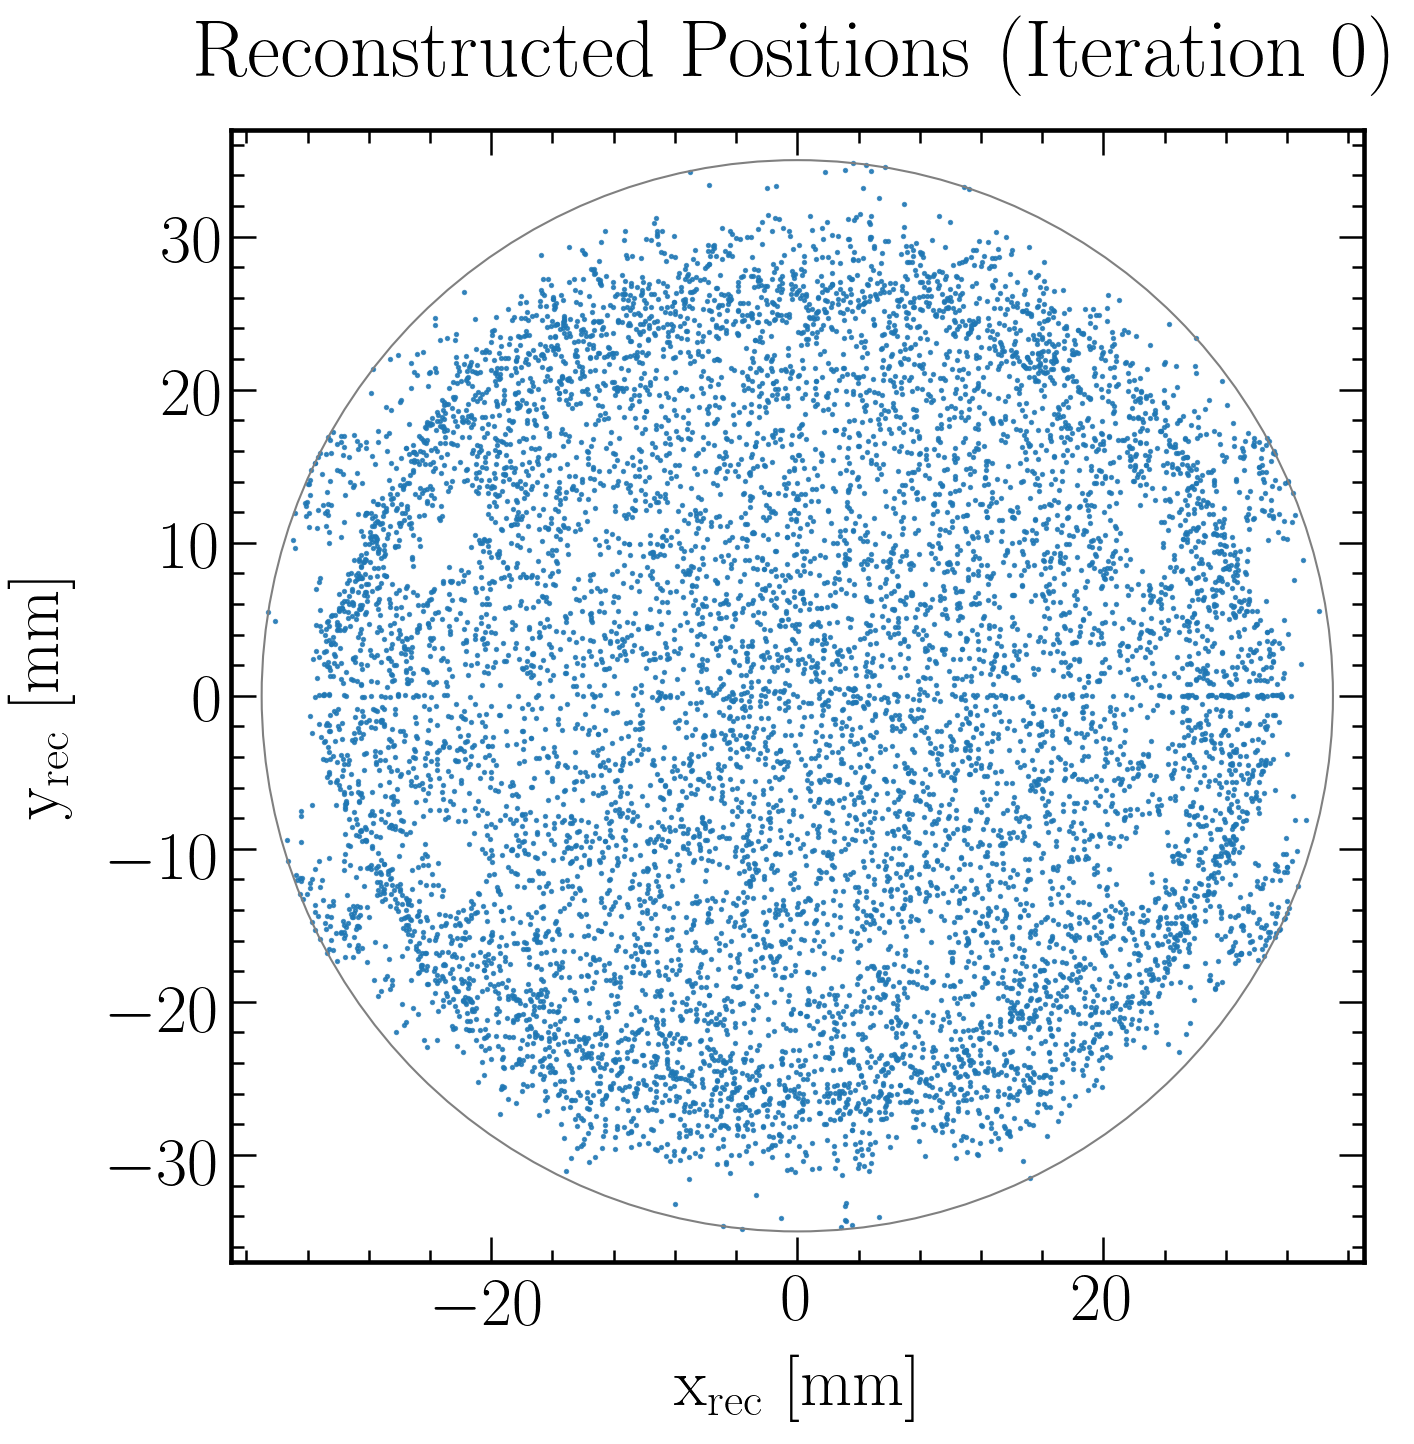

In [15]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(x_list, 
            y_list,
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (Iteration '+iteration+')', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_reconstructed_positions_iteration_"+iteration+".png", bbox_inches = "tight")

In [16]:
Iterative_Reconstruciton.head(2)

rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1         [None, None, None, None, None, None, None]   

                                               x_pos  \
0  [17.618000307344, 30.552376361769564, -15.4647...   
1                                               None   

                                               y_pos  \
0  [16.91237920021913, -2.033241012730516, 20.361...   
1                                               None   

                                 r_pos_binned HF_binned  \
0  [None, None, None, None, None, None, None]      None   
1  [None, None, None, None, None, None, None]      None   

                            fit_parameter_end  
0  [None, None, None, None, None, None, None]  
1  [None, None, None, None, None, None, None]

/home/ab602/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/ab602/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


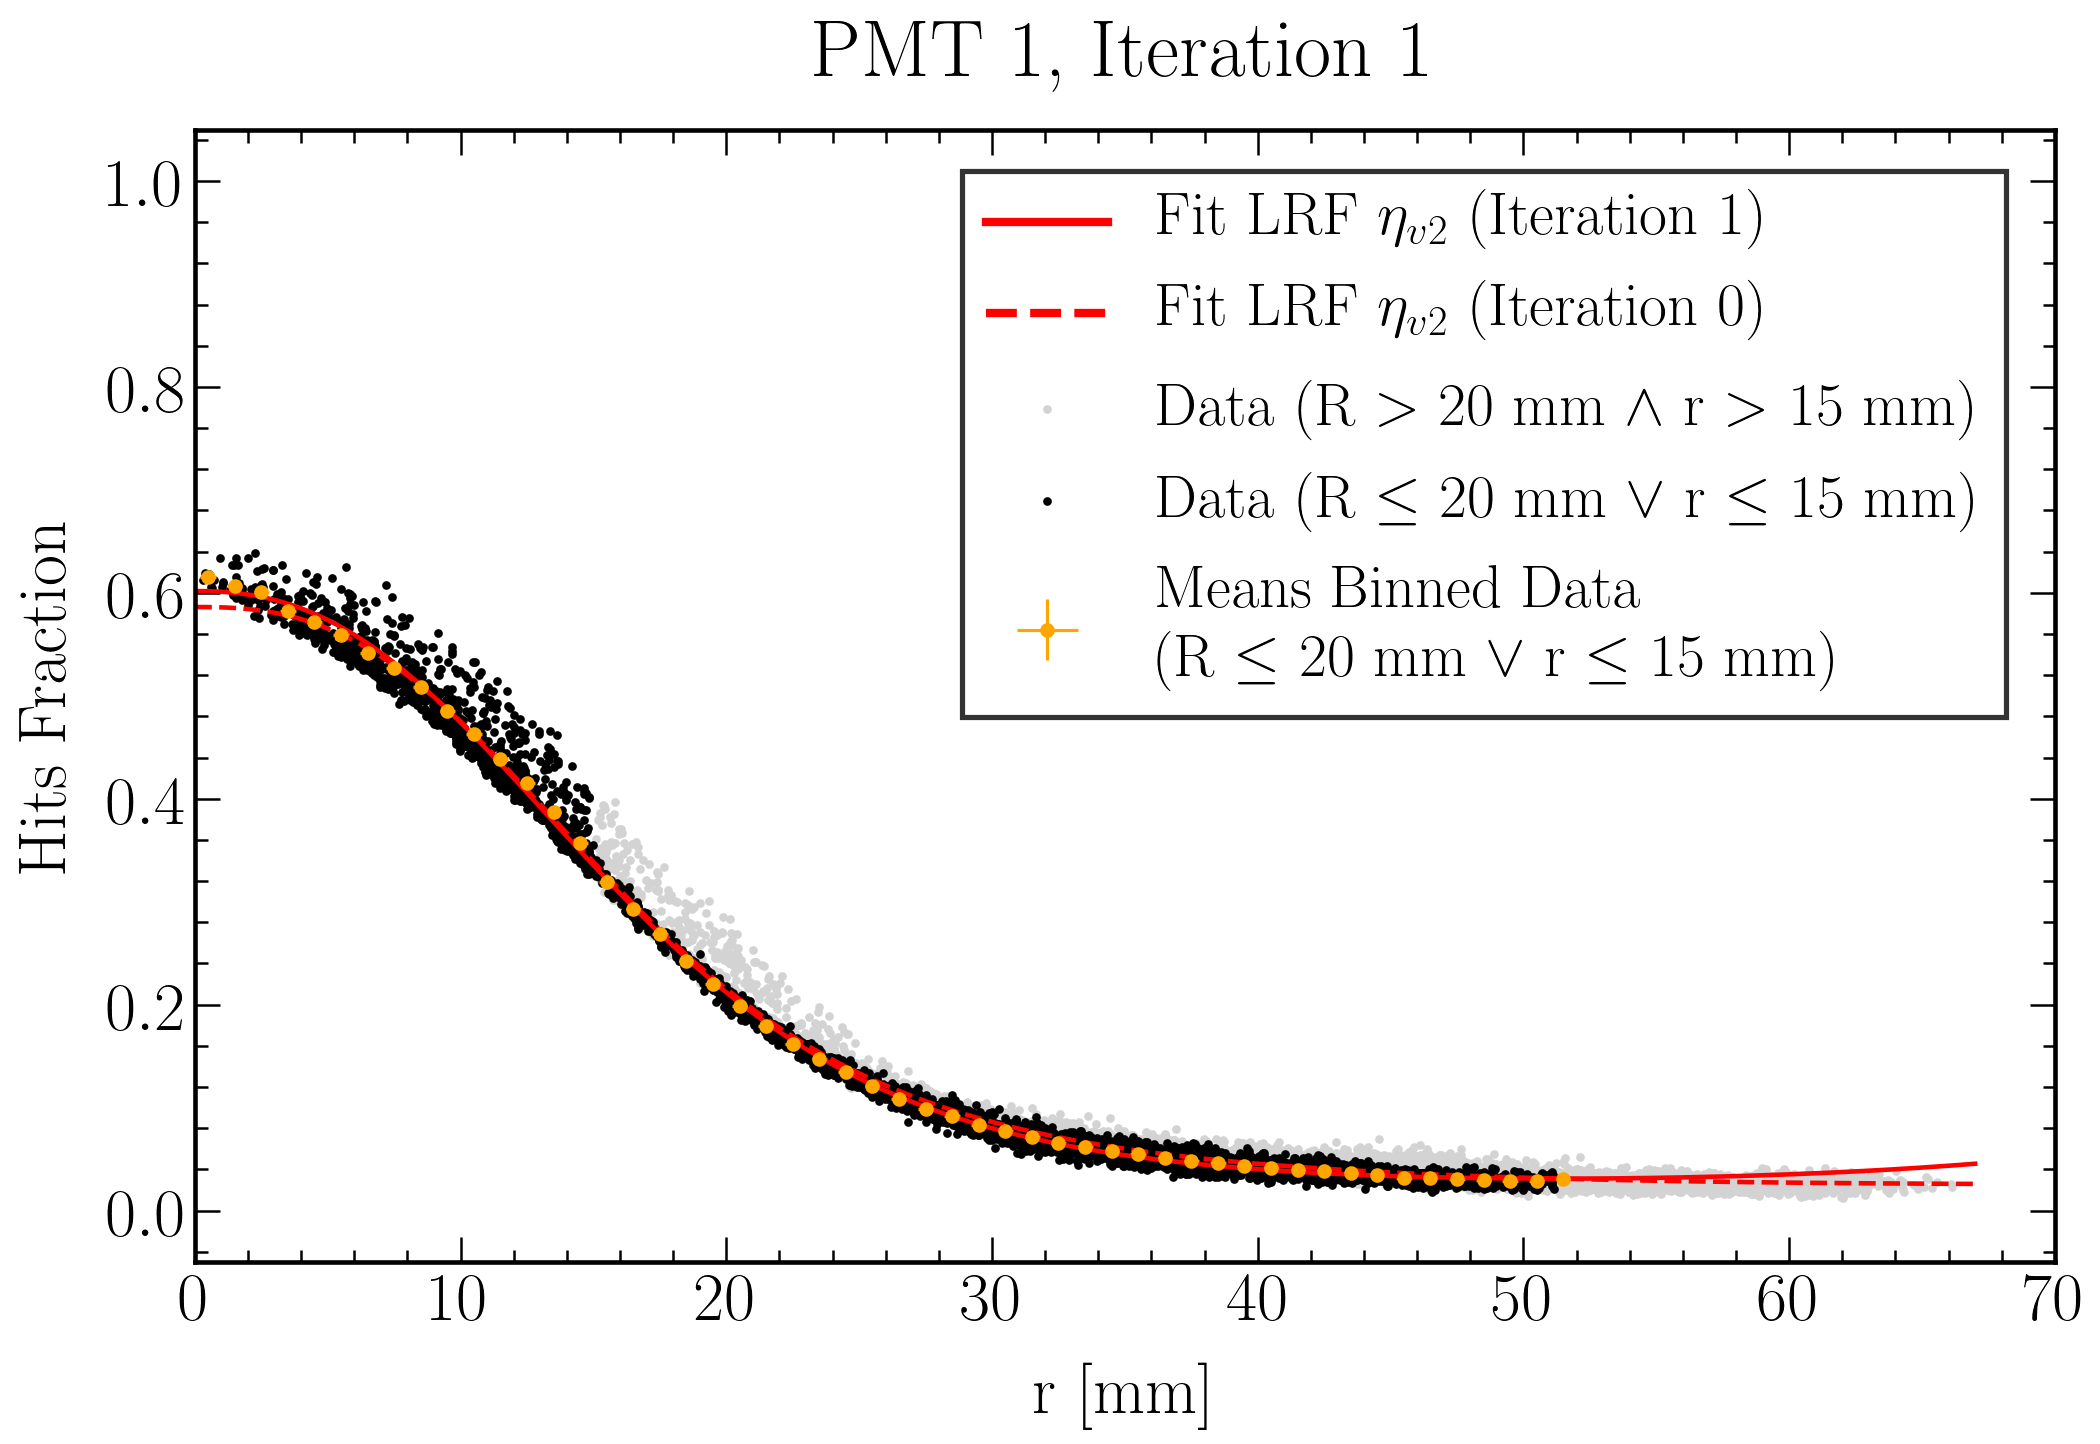

/home/ab602/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/ab602/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


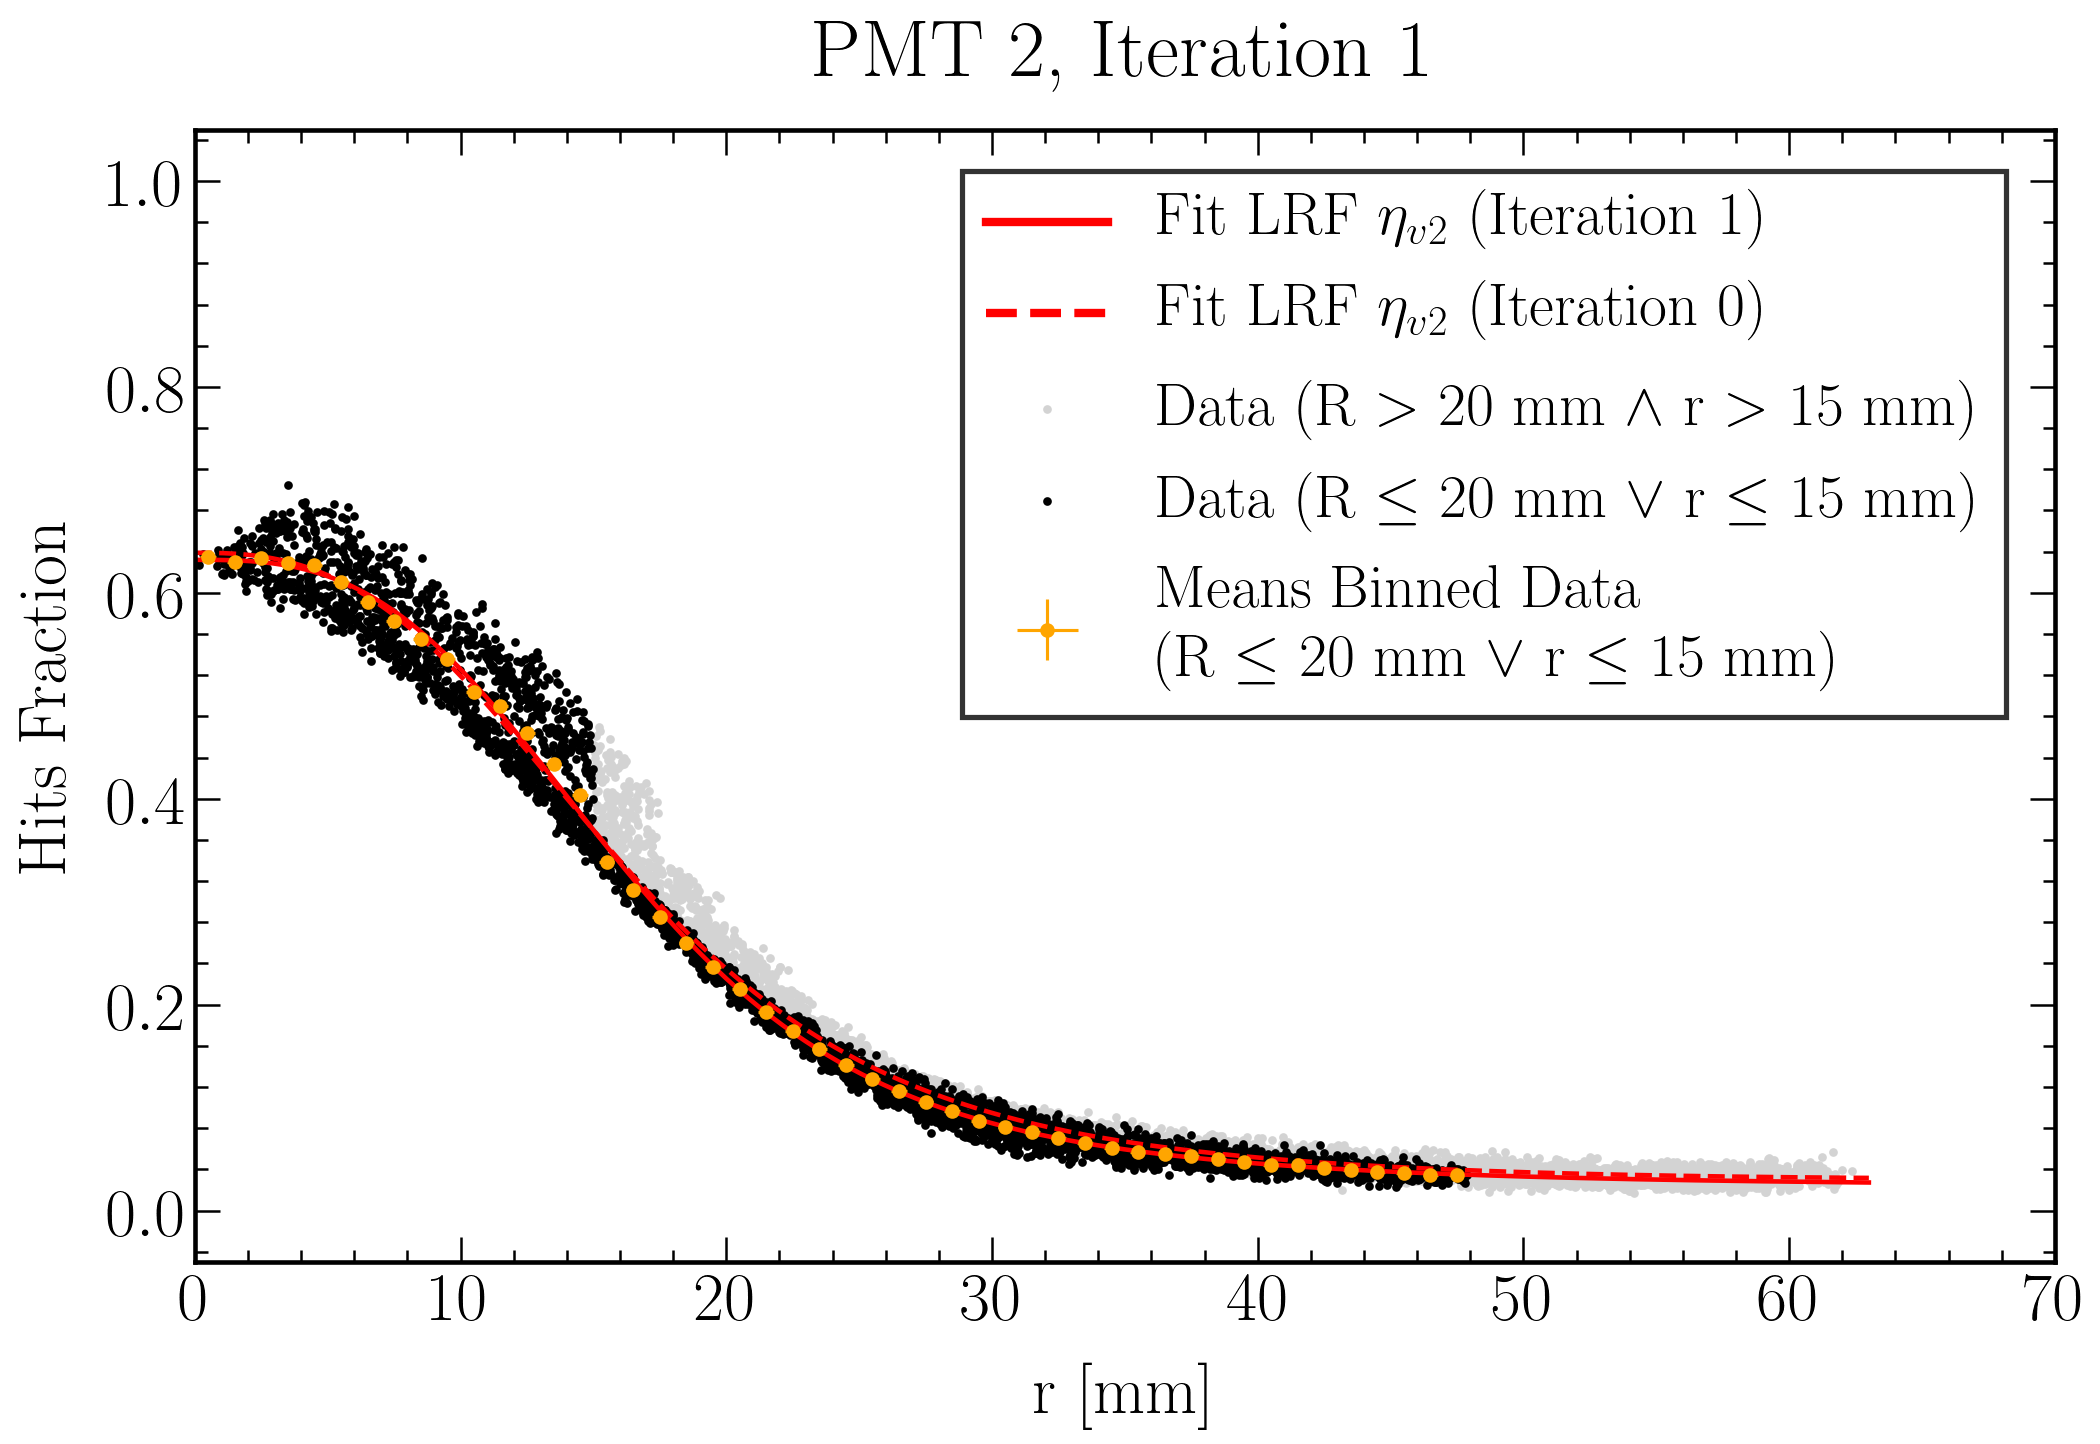

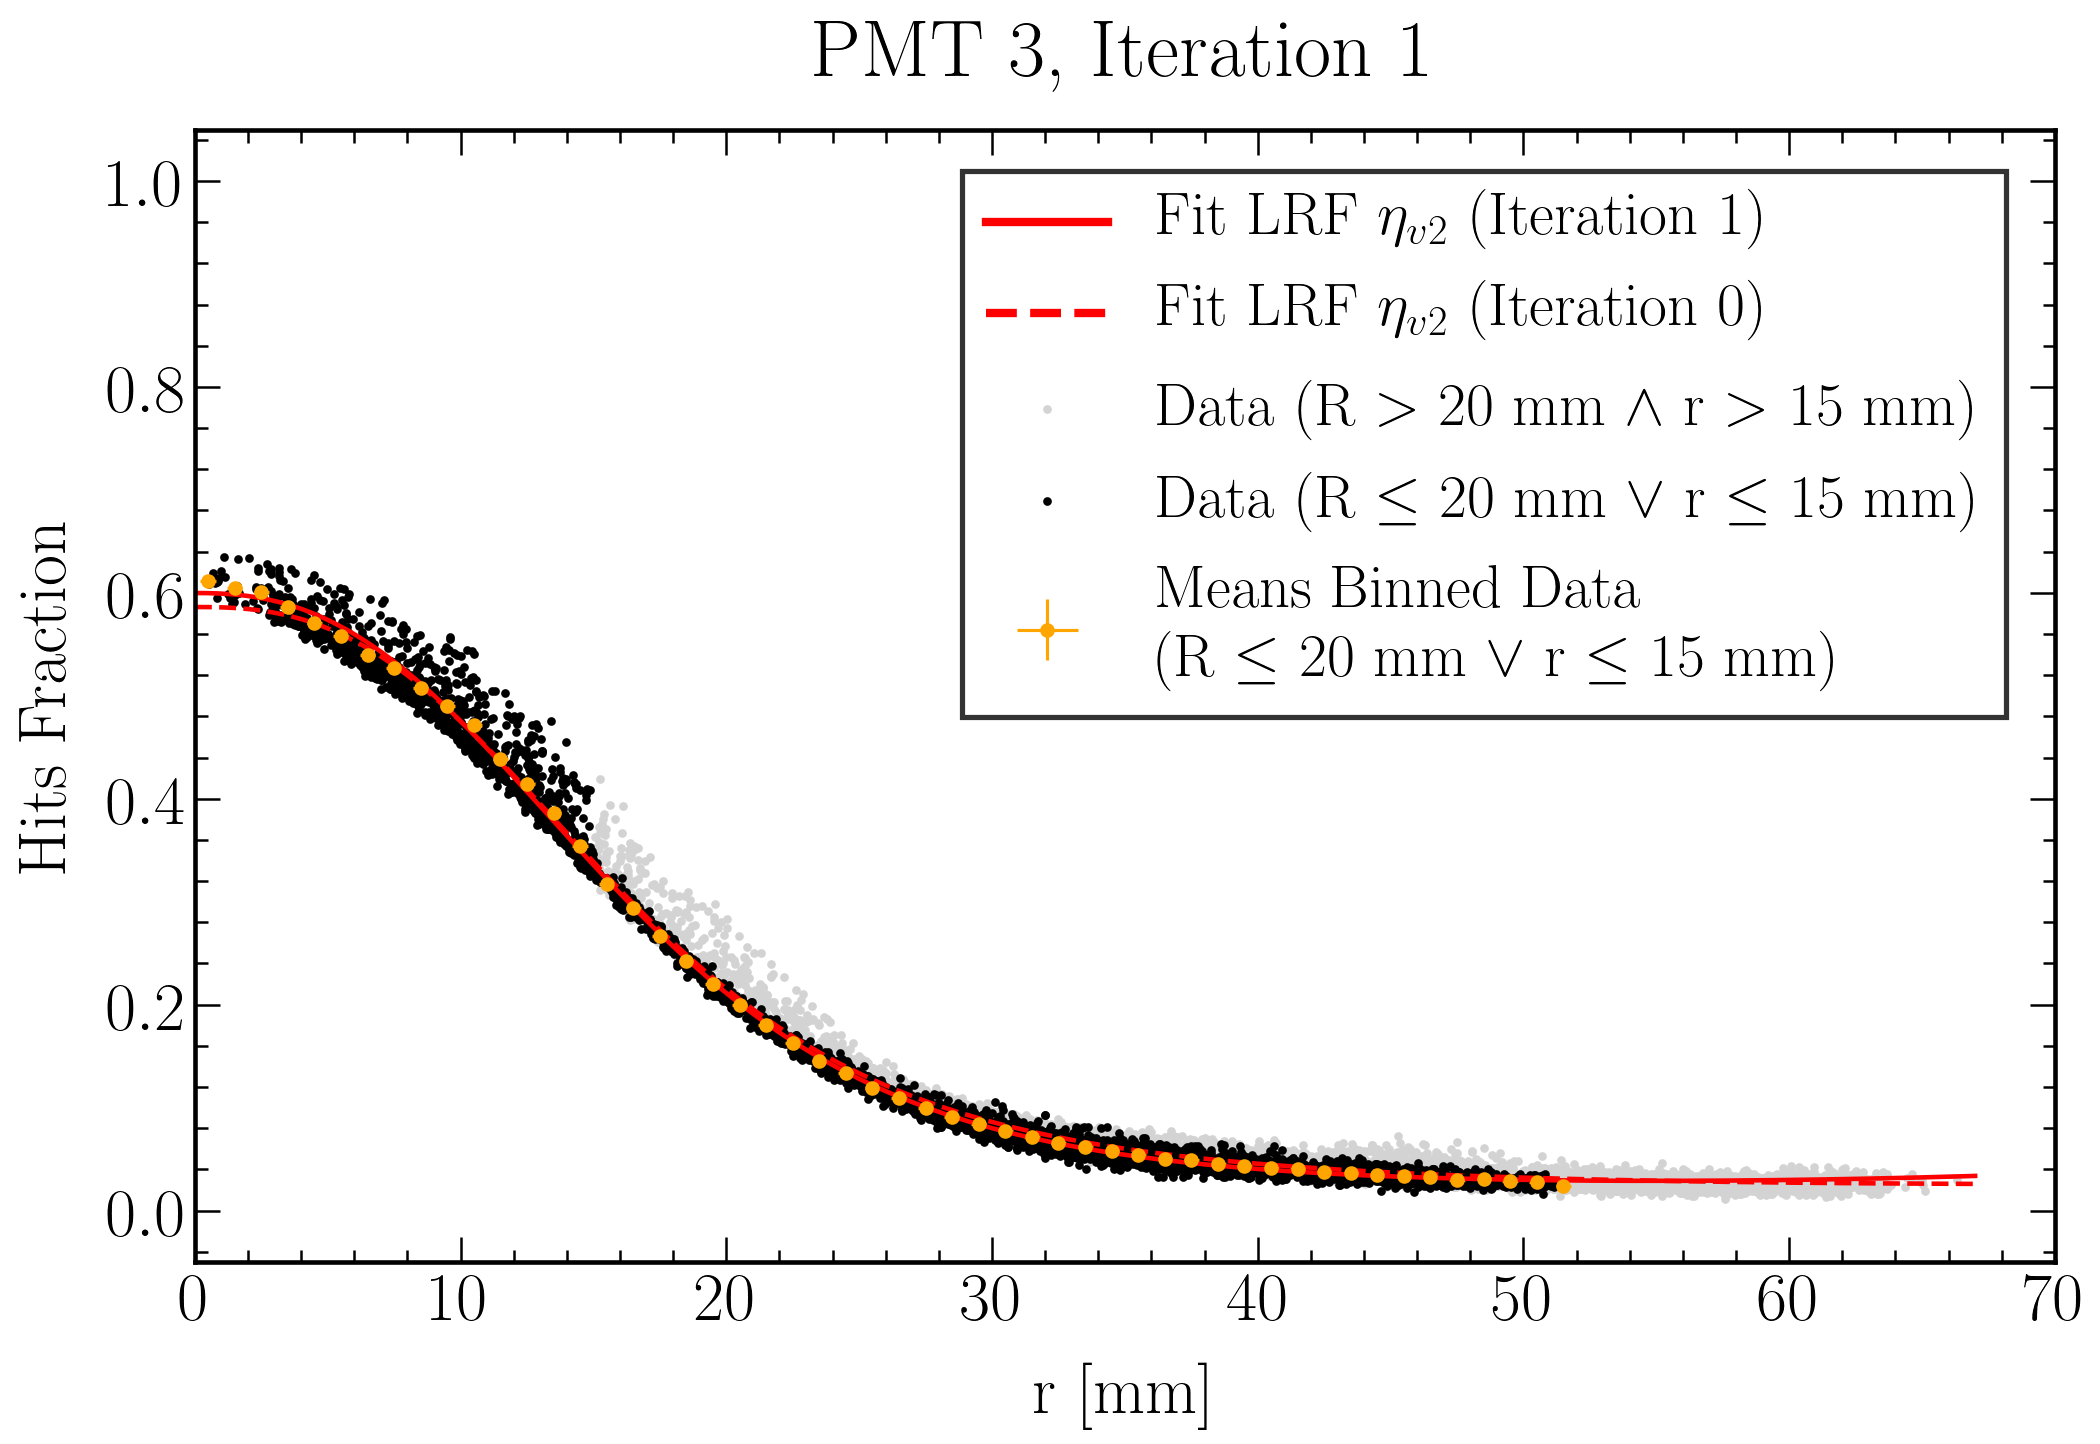

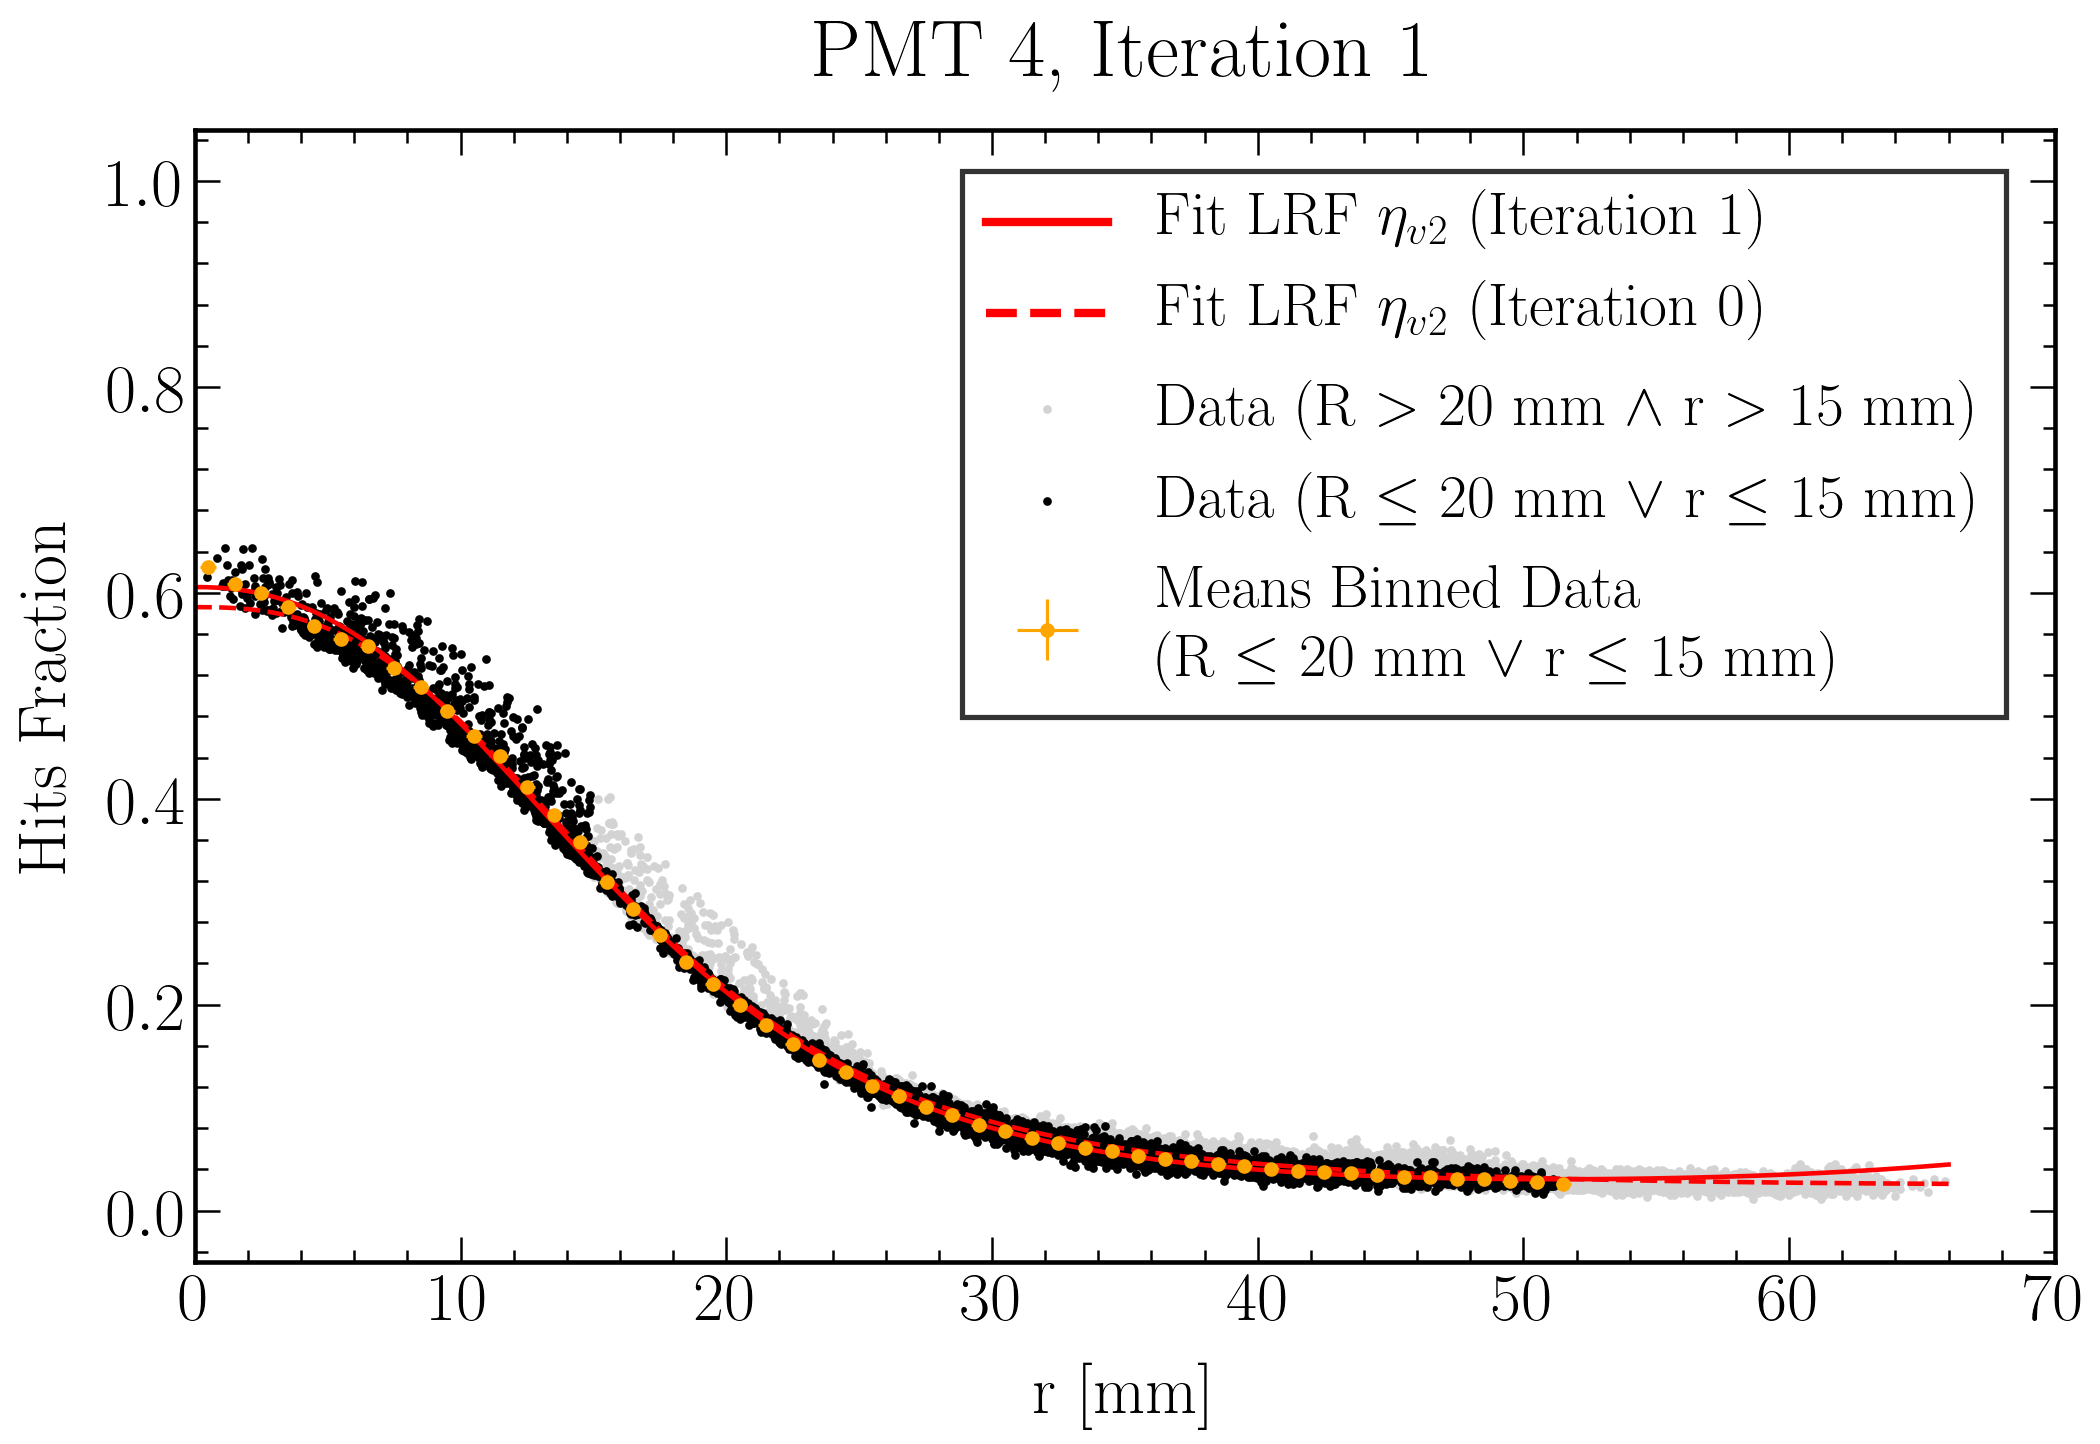

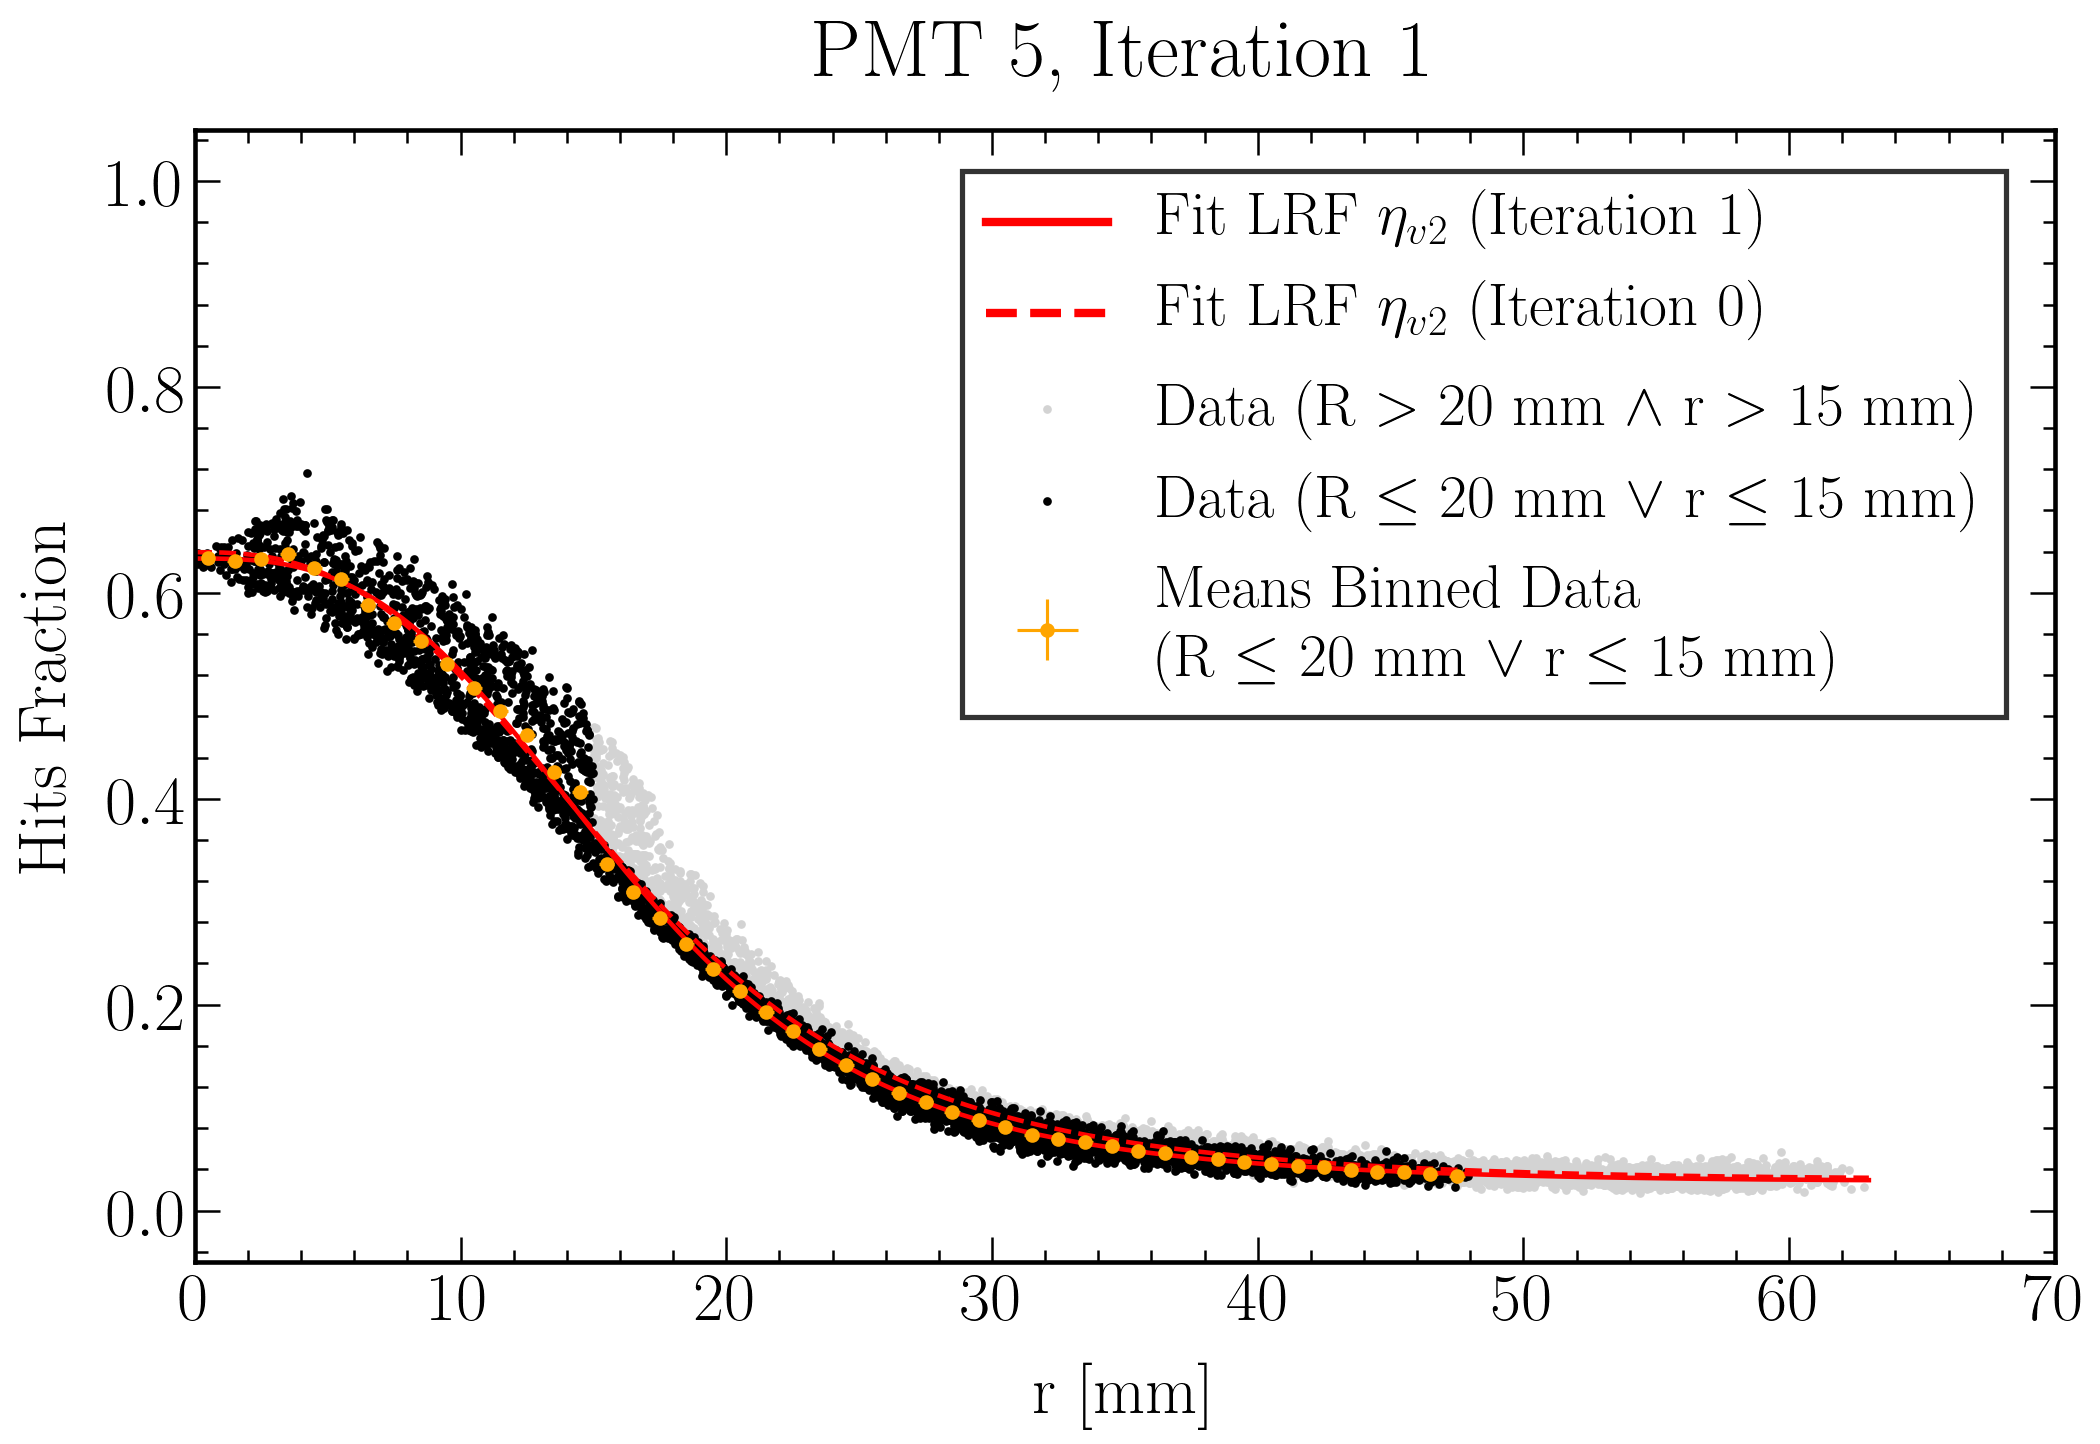

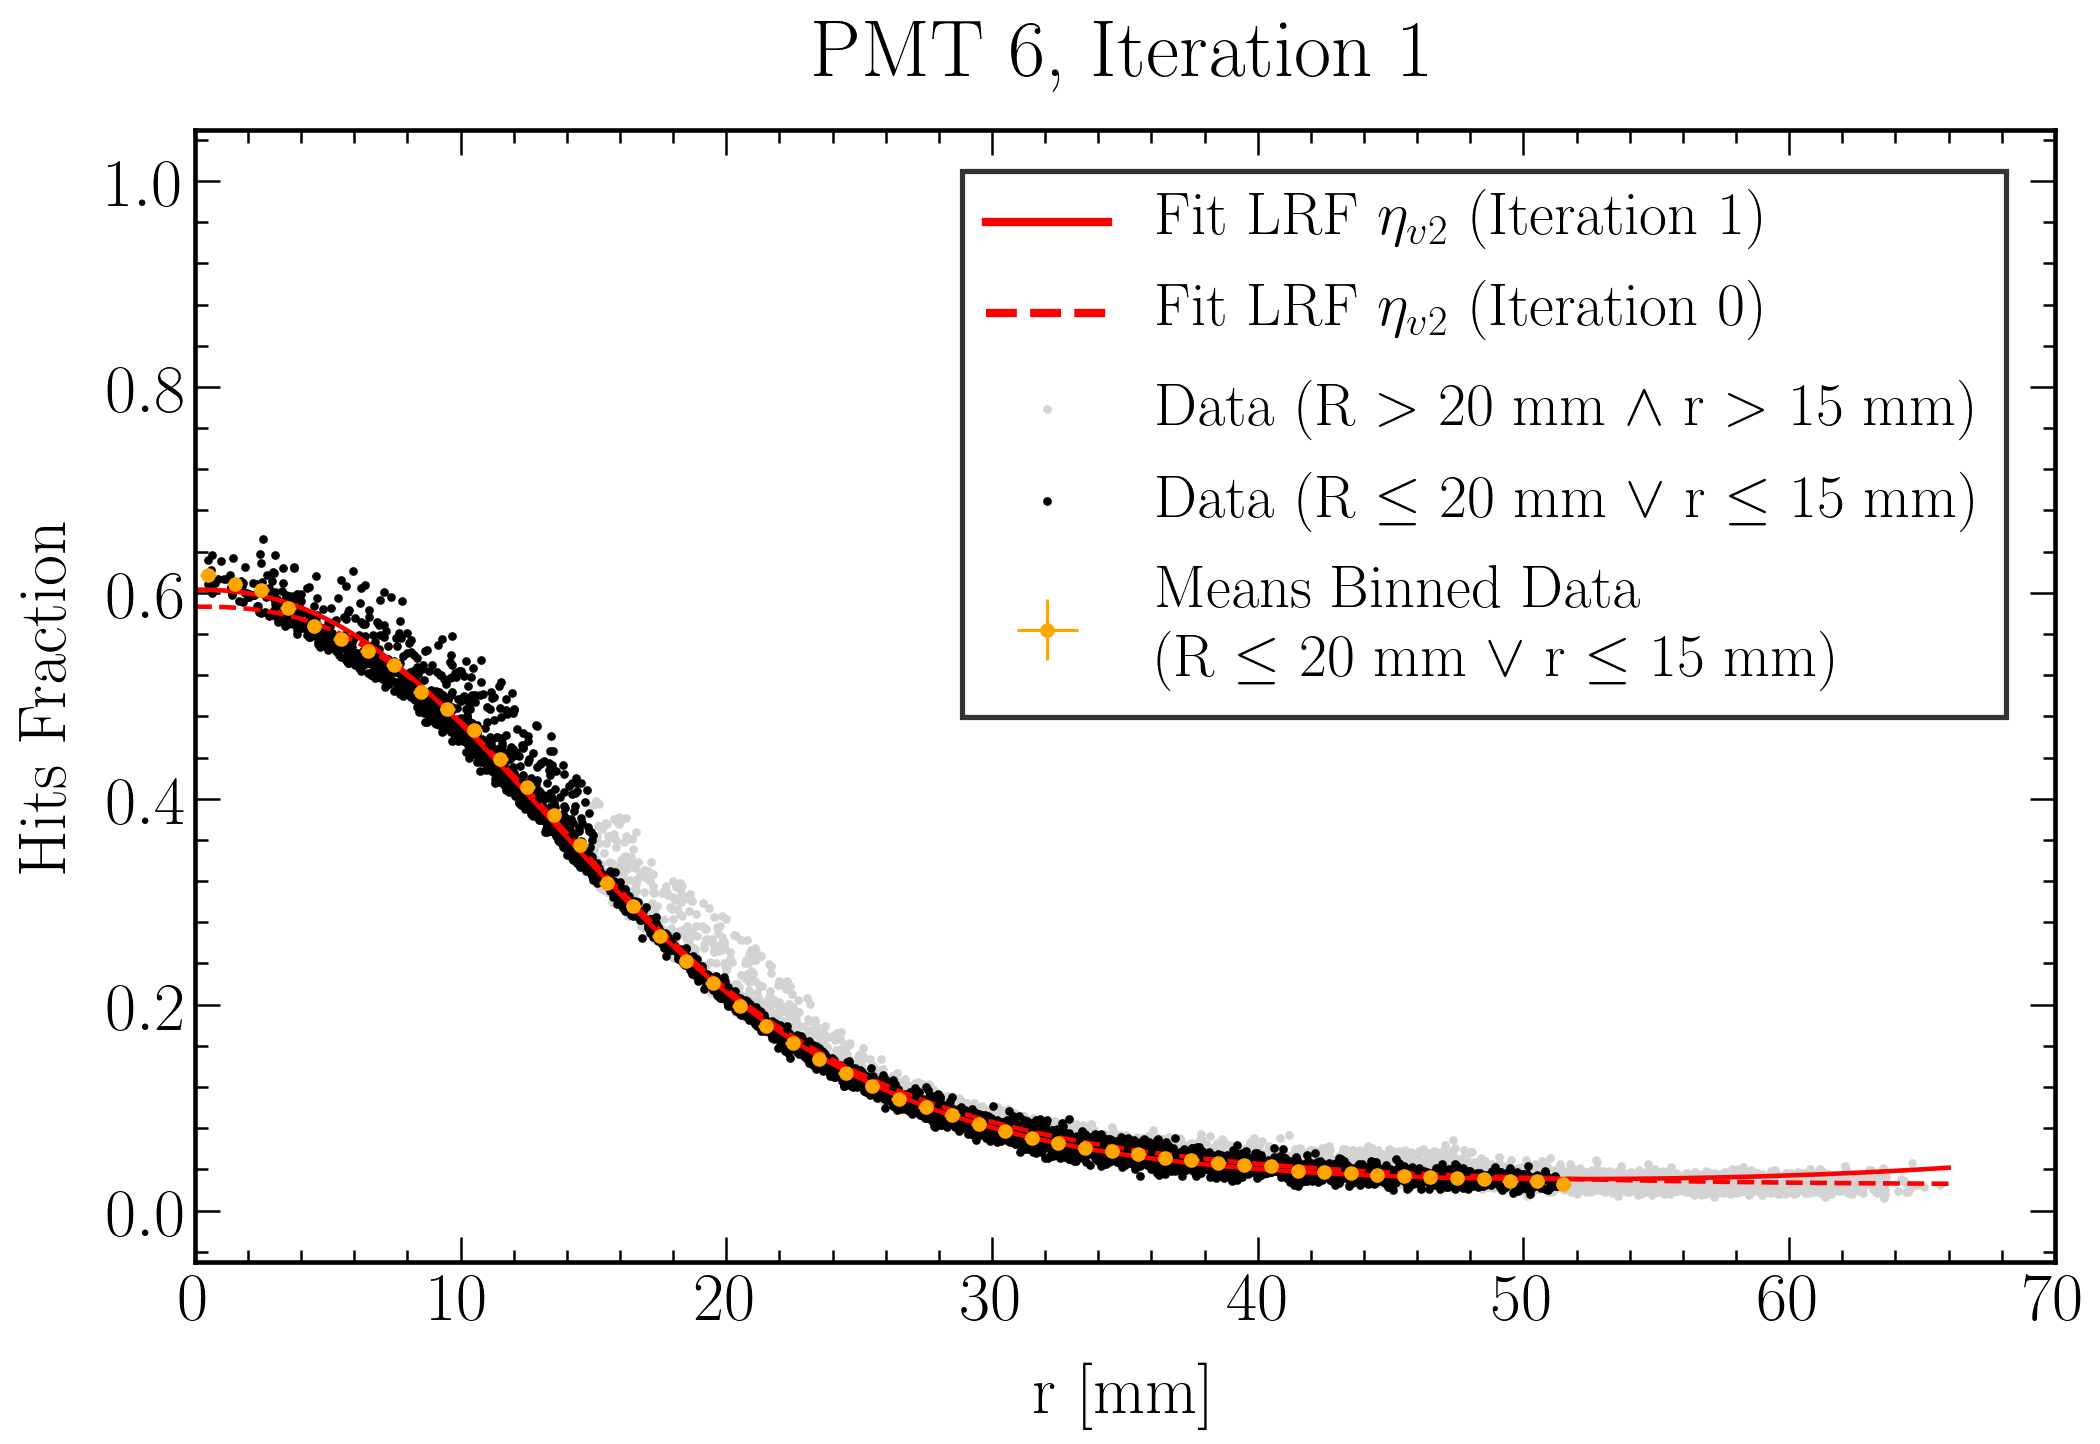

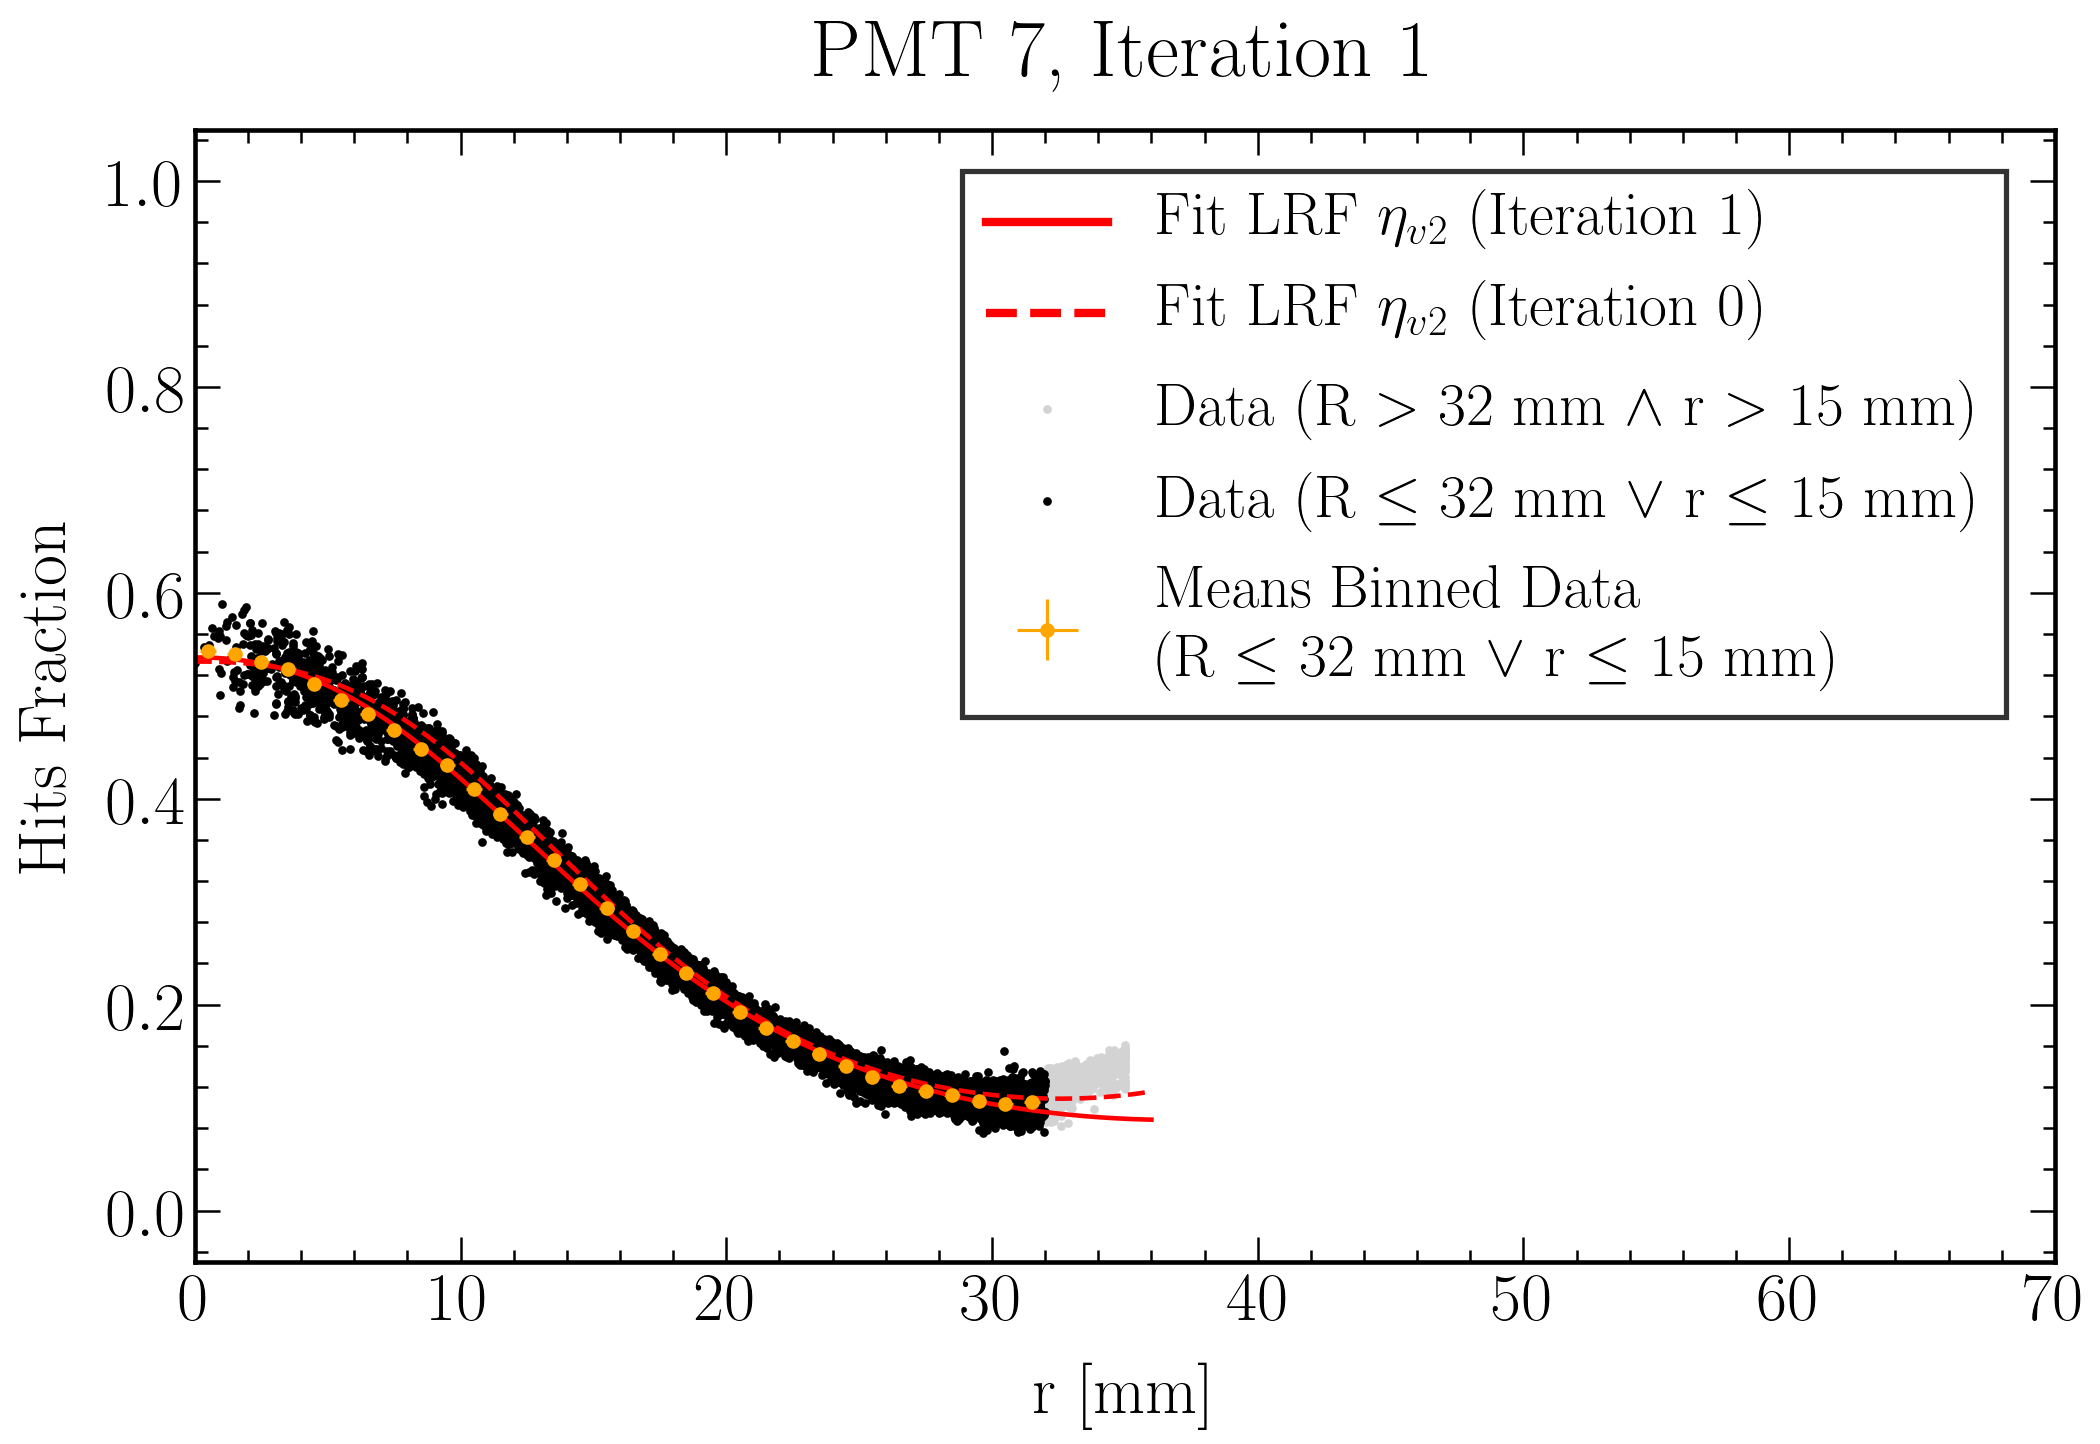

In [17]:
## Calculate radial positions
R_pos_list = np.hypot(Iterative_Reconstruciton.at[iteration, 'x_pos'], Iterative_Reconstruciton.at[iteration, 'y_pos'])
r_pos_list = np.array([np.hypot(Iterative_Reconstruciton.at[iteration, 'x_pos'] - PMT_positions['PMT_position_x'][i], Iterative_Reconstruciton.at[iteration, 'y_pos'] - PMT_positions['PMT_position_y'][i]) for i in range(1,8)])

## Create radial plots and perform fits
fit_parameters = np.array([None]*7)
r_pos_binned = np.array([None]*7)
HF_binned = np.array([None]*7)

for i in range(1,8):
    
    if i == 7:
        rfiducial = Iterative_Reconstruciton.at[iteration, 'rfiducial_central']
        rfiducial_under = Iterative_Reconstruciton.at[iteration, 'rfiducial_under']
    else:
        rfiducial = Iterative_Reconstruciton.at[iteration, 'rfiducial']
        rfiducial_under = Iterative_Reconstruciton.at[iteration, 'rfiducial_under']
    HF = HF_list[i-1]
    R = R_pos_list
    r = r_pos_list[i-1]
    
    ## Fiducialise
    r_fiducial = r[(R <= rfiducial) | (r <= rfiducial_under)]
    HF_fiducial = HF[(R <= rfiducial) | (r <= rfiducial_under)]
    r_fiducial_complementary = r[(R > rfiducial) & (r > rfiducial_under)]
    HF_fiducial_complementary = HF[(R > rfiducial) & (r > rfiducial_under)]
    
    ## Bin to account for different arc lengths
    statistic, bin_edges, binnumber = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='mean', bins=(70), range=(0,70))
    bin_center = (bin_edges[:-1]+bin_edges[1:])/2
    statistic_isnan = statistic[~np.isnan(statistic)]
    bin_center_isnan = bin_center[~np.isnan(statistic)]
    
    statistic_std, _, _ = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='std', bins=(70), range=(0,70))
    statistic_std_isnan = statistic_std[~np.isnan(statistic)]
    
    statistic_count, _, _ = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='count', bins=(70), range=(0,70))
    statistic_count_isnan = statistic_count[~np.isnan(statistic)]

    r_pos_binned[i-1] = bin_center_isnan
    HF_binned[i-1] = statistic_isnan
    
    '''## Fit
    if modelstring == 'eta_v2':
        bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
        popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan, bounds = bnds)
    else:
        popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan)
    fit_parameters[i-1] = popt
    '''
    
    try: 
        if (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)<0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1<1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan, bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan)
            fit_parameters[i-1] = popt
        elif (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)>=0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1<1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[1:], statistic_isnan[1:], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[1:], statistic_isnan[1:])
            fit_parameters[i-1] = popt
        elif (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)<0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1>=1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[:-1], statistic_isnan[:-1], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[:-1], statistic_isnan[:-1])
            fit_parameters[i-1] = popt
        else:
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1])
            fit_parameters[i-1] = popt
    except:
        if modelstring == 'eta_v2':
            bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
            popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1], bounds = bnds)
        else:
            popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1])
        fit_parameters[i-1] = popt
    
    ##################################################################################################
    #### Plot

    fig=plt.figure(figsize=(16, 10), dpi=150)

    ## Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    ## Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    ## Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    ## Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    ## Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    ## Grid
    #plt.grid(True)

    if rfiducial_under > 0:
        lbl = "Data (R $>$ "+str(rfiducial)+" mm $\land$ r $>$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Data (R $>$ "+str(rfiducial)+" mm)"
    plt.scatter(r_fiducial_complementary, HF_fiducial_complementary, s=10, color = 'lightgray', label = lbl)
    if rfiducial_under > 0:
        lbl = "Data (R $\leq$ "+str(rfiducial)+" mm $\lor$ r $\leq$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Data (R $\leq$ "+str(rfiducial)+" mm)"
    plt.scatter(r_fiducial, HF_fiducial, color = 'black', s=10, label = lbl)
    if rfiducial_under > 0:
        lbl = "Means Binned Data\n(R $\leq$ "+str(rfiducial)+" mm $\lor$ r $\leq$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Means Binned Data\n(R $\leq$ "+str(rfiducial)+" mm)"
    plt.errorbar(bin_center_isnan, statistic_isnan, 
                 yerr=statistic_std_isnan/np.sqrt(statistic_count_isnan), 
                 xerr = (70/70)/np.sqrt(12), fmt='o', color = 'orange', 
                 label = lbl)
    
    if int(modelstring[-1]) == 1:
        label = 'Fit LRF $\eta_{v1}$'
    elif int(modelstring[-1]) == 2:
        label = 'Fit LRF $\eta_{v2}$'
    elif int(modelstring[-1]) == 3:
        label = 'Fit LRF $\eta_{v3}$'
    elif int(modelstring[-1]) == 4:
        label = 'Fit LRF $\eta_{v4}$'
    else:
        label = 'Fit LRF'
    plt.plot(np.linspace(0, math.ceil(np.max(r)), 300), model(np.linspace(0, math.ceil(np.max(r)), 300), *eval("fit_parameters")[i-1]), color = 'r', linewidth = 2.2, label = label+' (Iteration '+str(eval(iteration+'+1'))+')')
    plt.plot(np.linspace(0, math.ceil(np.max(r)), 300), model(np.linspace(0, math.ceil(np.max(r)), 300), *np.array(Iterative_Reconstruciton["fit_parameter"]["0"].tolist())[i-1]), color = 'r', linewidth = 2.2, label = label+' (Iteration 0)', linestyle = 'dashed')
    
    plt.xlim(0.,35.*2)
    plt.ylim(-0.05, 1.05)
    
    # Axes Label 
    plt.xlabel('r [mm]', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
    plt.title('PMT '+str(i)+', Iteration '+str(eval(iteration+'+1')), fontsize = title_size, pad = title_pad)
    
    # Legend
    leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_Iterative_Reconstruciton_iteration_"+str(eval(iteration+'+1'))+"_PMT_"+str(i)+".png")
    plt.show()
    #################################################################################################

    ## Write to dataframe
    Iterative_Reconstruciton.at[iteration, 'r_pos_binned'] = r_pos_binned
    Iterative_Reconstruciton.at[iteration, 'HF_binned'] = HF_binned
    
Iterative_Reconstruciton.at[str(eval(iteration+'+1')), 'fit_parameter'] = fit_parameters
Iterative_Reconstruciton.at[iteration, 'fit_parameter_end'] = fit_parameters

In [18]:
Iterative_Reconstruciton.head(2)

rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1  [[0.6017073963620089, 38.7302590431945, -4.027...   

                                               x_pos  \
0  [17.618000307344, 30.552376361769564, -15.4647...   
1                                               None   

                                               y_pos  \
0  [16.91237920021913, -2.033241012730516, 20.361...   
1                                               None   

                                        r_pos_binned  \
0  [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,...   
1         [None, None, None, None, None, None, None]   

                                           HF_binned  \
0  [[0.6149924051067908, 0.6068165928205498, 0.60...   
1                                               None   

                                   fit_parameter_end  
0  [[0.6017073963620089, 38.7302590431945, -4.027...  
1         [None, None, None, None, None, None, None]

### Iteration >= 1

In [43]:
########################
iteration = '5'
########################

iteration_previous = str(int(iteration)-1)

try:
    if Iterative_Reconstruciton['fit_parameter'][iteration_previous][0] is not None:
        Iterative_Reconstruciton['fit_parameter'][iteration_previous]
    else:
        print('Previous iteration '+iteration_previous+' is not yet processed, will therefore set iteration to 1!')
        iteration = '1'     
except:
    print('Failed to set iteration to '+iteration+', will therefore set it to 1!')
    iteration = '1'

iteration_previous = str(int(iteration)-1)

print('current iteration  = '+iteration)
print('previous iteration = '+iteration_previous)

#####

fit_parameters = Iterative_Reconstruciton['fit_parameter'][iteration]
#HF_list = HF_list

current iteration  = 5
previous iteration = 4


In [44]:
# Reconstruct position

rng = HF_list[0].shape[0]
x_list = np.full(rng, np.nan) # np.array([None]*(rng))
y_list = np.full(rng, np.nan) # np.array([None]*(rng))

printlevel = 0
for i in  range(0, rng):
    HF = [HF_list[j][i] for j in range(0,7)]
    pos = reconstructed(HF, fit_parameters).x
    x_list[i] = pos[0]
    y_list[i] = pos[1]
    
    if i / rng >= printlevel:
        print(str(100 * round(printlevel, 1))+' %', end = ' ')
        printlevel += 0.1
print('100 %', end = ' ')
    
Iterative_Reconstruciton.at[iteration, 'x_pos'] = x_list # np.array(x_list.tolist())
Iterative_Reconstruciton.at[iteration, 'y_pos'] = y_list # np.array(y_list.tolist())

0 % 10.0 % 20.0 % 30.0 % 40.0 % 50.0 % 60.0 % 70.0 % 80.0 % 90.0 % 100 % 

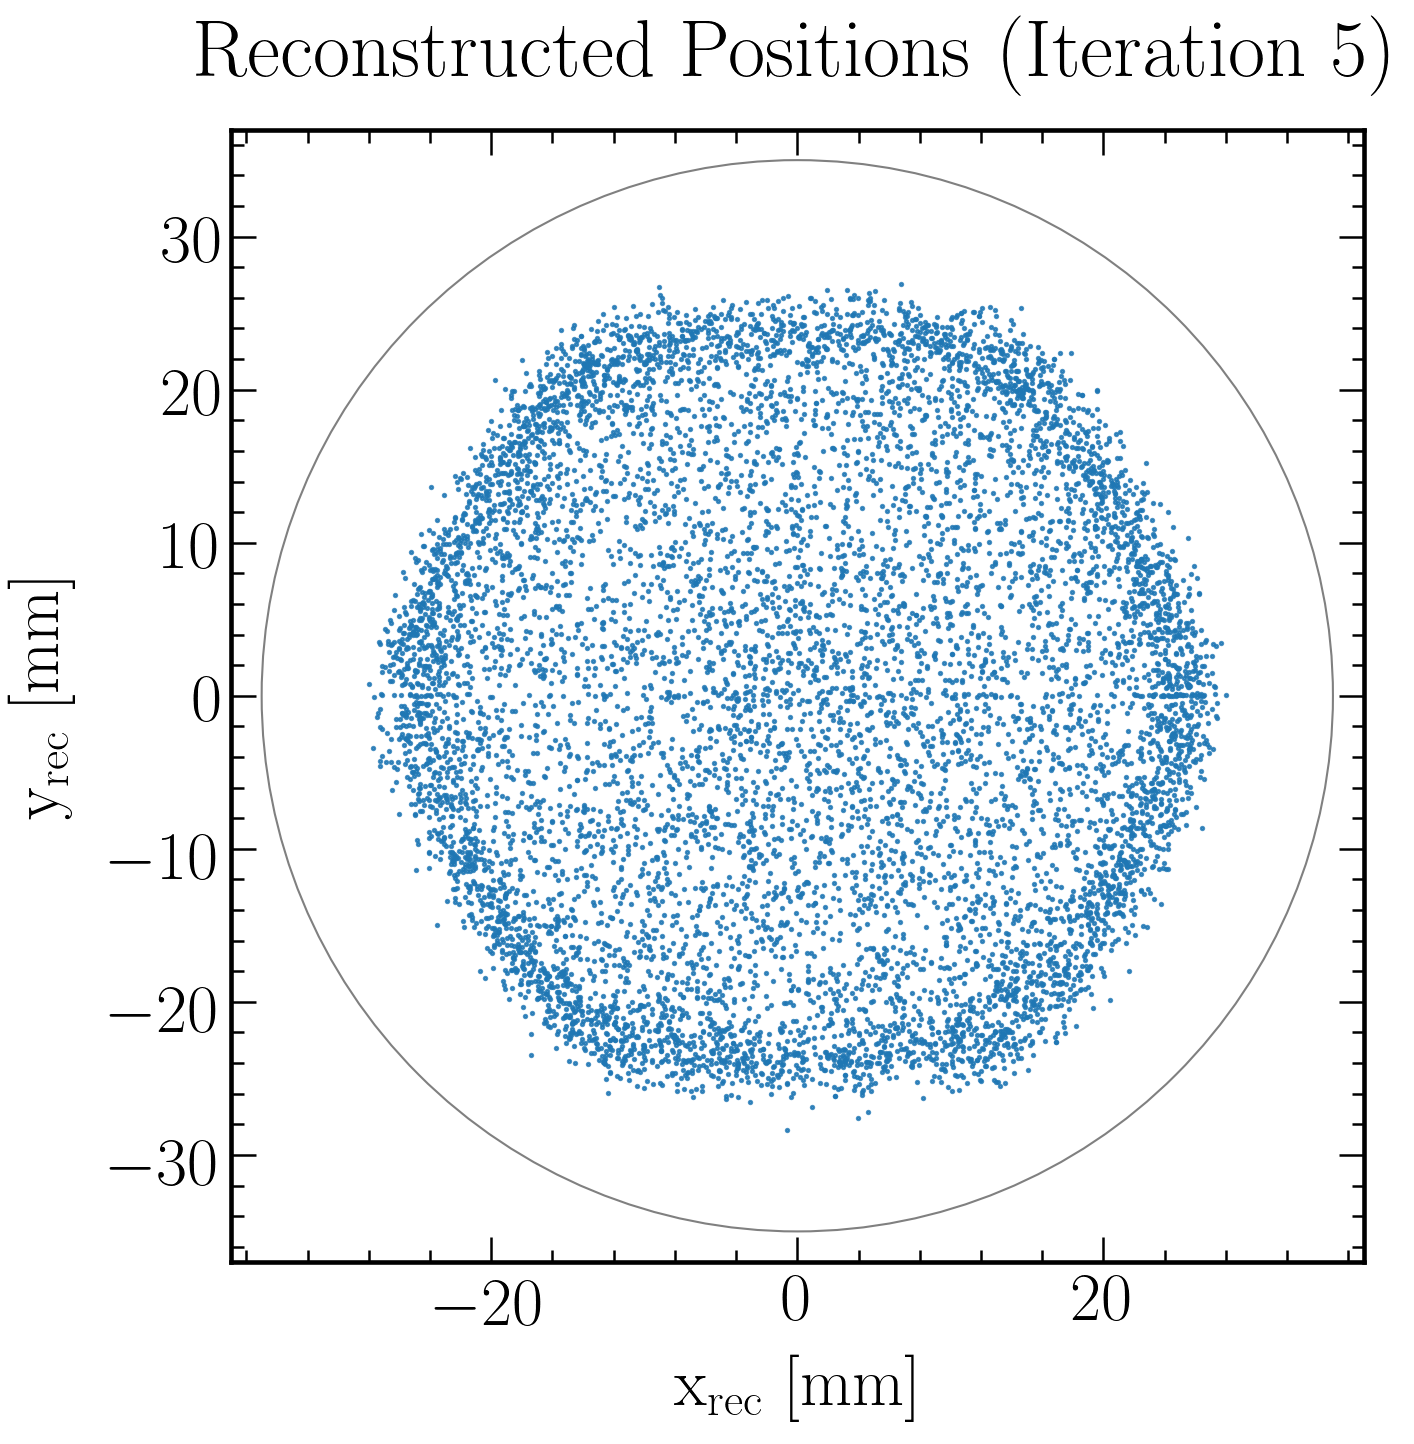

In [45]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(x_list, 
            y_list,
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (Iteration '+iteration+')', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_reconstructed_positions_iteration_"+iteration+".png", bbox_inches = "tight")

In [46]:
Iterative_Reconstruciton.head(eval(iteration+'+1'))

rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   
2         20               15                 32   
3         20               15                 32   
4         20               15                 32   
5         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1  [[0.6017073963620089, 38.7302590431945, -4.027...   
2  [[0.6183459043835552, 43.129166330359276, -6.3...   
3  [[0.627798381471581, 48.34741093020025, -10.55...   
4  [[0.6345135617096274, 51.75905632867351, -13.8...   
5  [[0.6349043341807443, 51.02000844229367, -13.2...   

                                               x_pos  \
0  [17.618000307344, 30.552376361769564, -15.4647...   
1  [17.3013291457405, 30.455956351607558, -15.082...   
2  [16.93612236692497, 30.154250957850888, -14.76...   
3  [16.615216386266592, 29.431376473767866, -14.5...   
4  [16.366924245315598, 28.182165820505343, -14.3...   
5  [16.142382994897247, 27.392299857756285, -14.1...   

                                               y_pos  \
0  [16.91237920021913, -2.033241012730516, 20.361...   
1  [16.582137440360153, -2.0807944665584777, 19.6...   
2  [16.329175822028212, -1.996003322743022, 19.31...   
3  [16.096415515672177, -1.7864947948697543, 19.1...   
4  [15.900474259618305, -1.5392371168293755, 19.0...   
5  [15.741791383200976, -1.4590623396973303, 18.8...   

                                        r_pos_binned  \
0  [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,...   
1  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
2  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
3  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
4  [[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5...   
5         [None, None, None, None, None, None, None]   

                                           HF_binned  \
0  [[0.6149924051067908, 0.6068165928205498, 0.60...   
1  [[0.6306566897637992, 0.6148077704403064, 0.59...   
2  [[0.6381987577639752, 0.6234712766152656, 0.61...   
3  [[0.6381987577639752, 0.6338842975206612, 0.61...   
4  [[0.6381987577639752, 0.6224500911273406, 0.60...   
5                                               None   

                                   fit_parameter_end  
0  [[0.6017073963620089, 38.7302590431945, -4.027...  
1  [[0.6183459043835552, 43.129166330359276, -6.3...  
2  [[0.627798381471581, 48.34741093020025, -10.55...  
3  [[0.6345135617096274, 51.75905632867351, -13.8...  
4  [[0.6349043341807443, 51.02000844229367, -13.2...  
5         [None, None, None, None, None, None, None]

/home/ab602/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/ab602/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


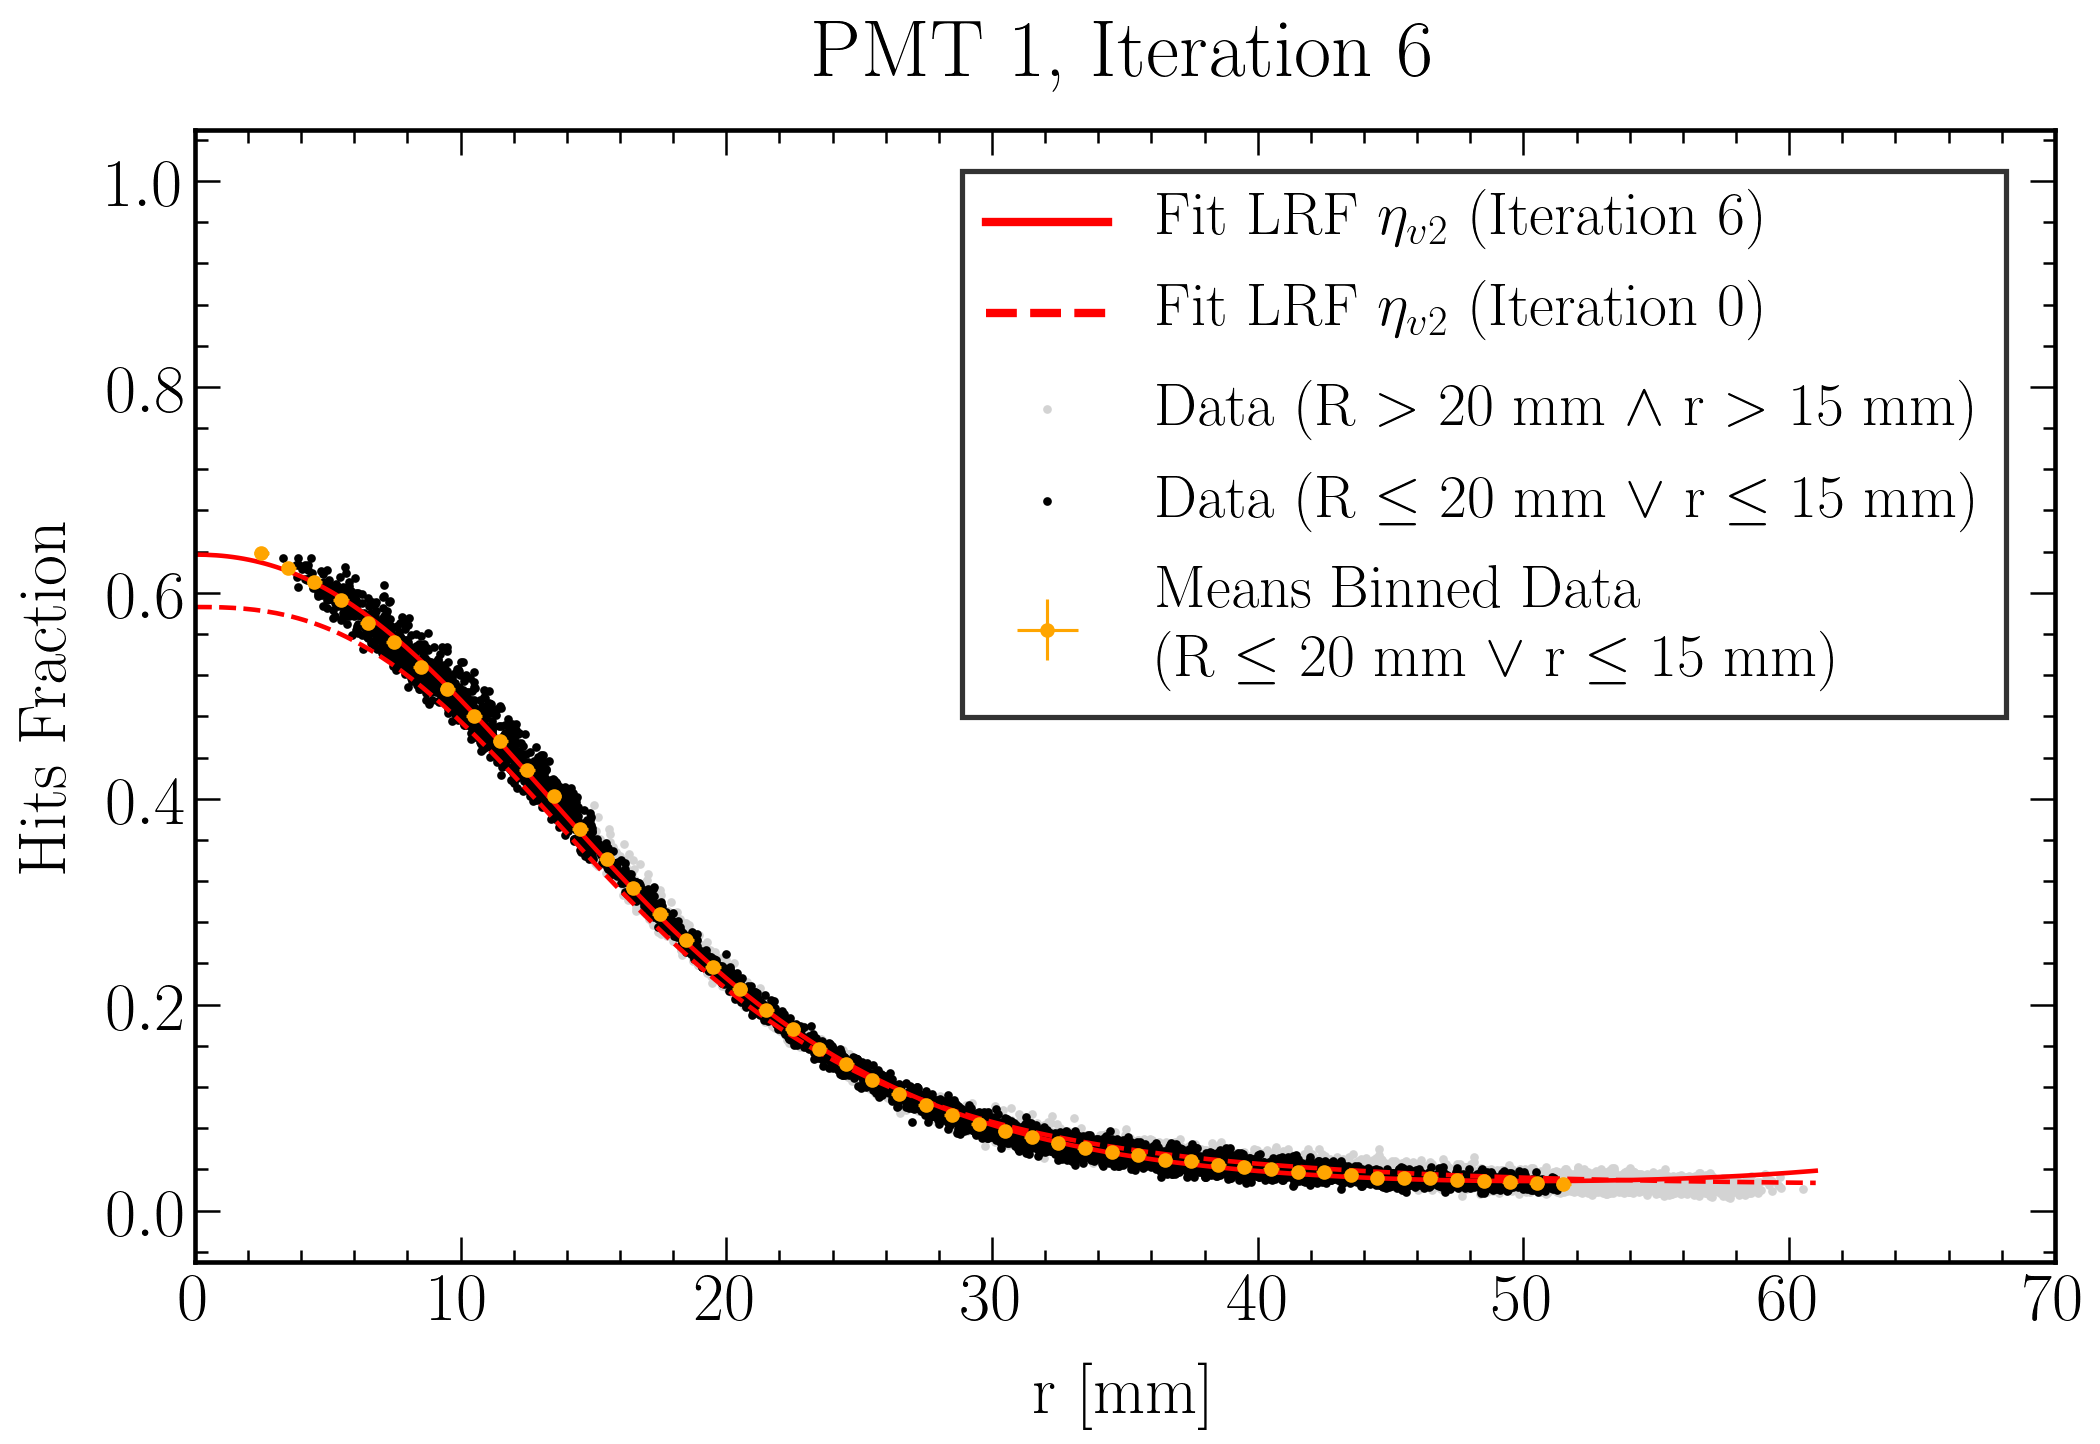

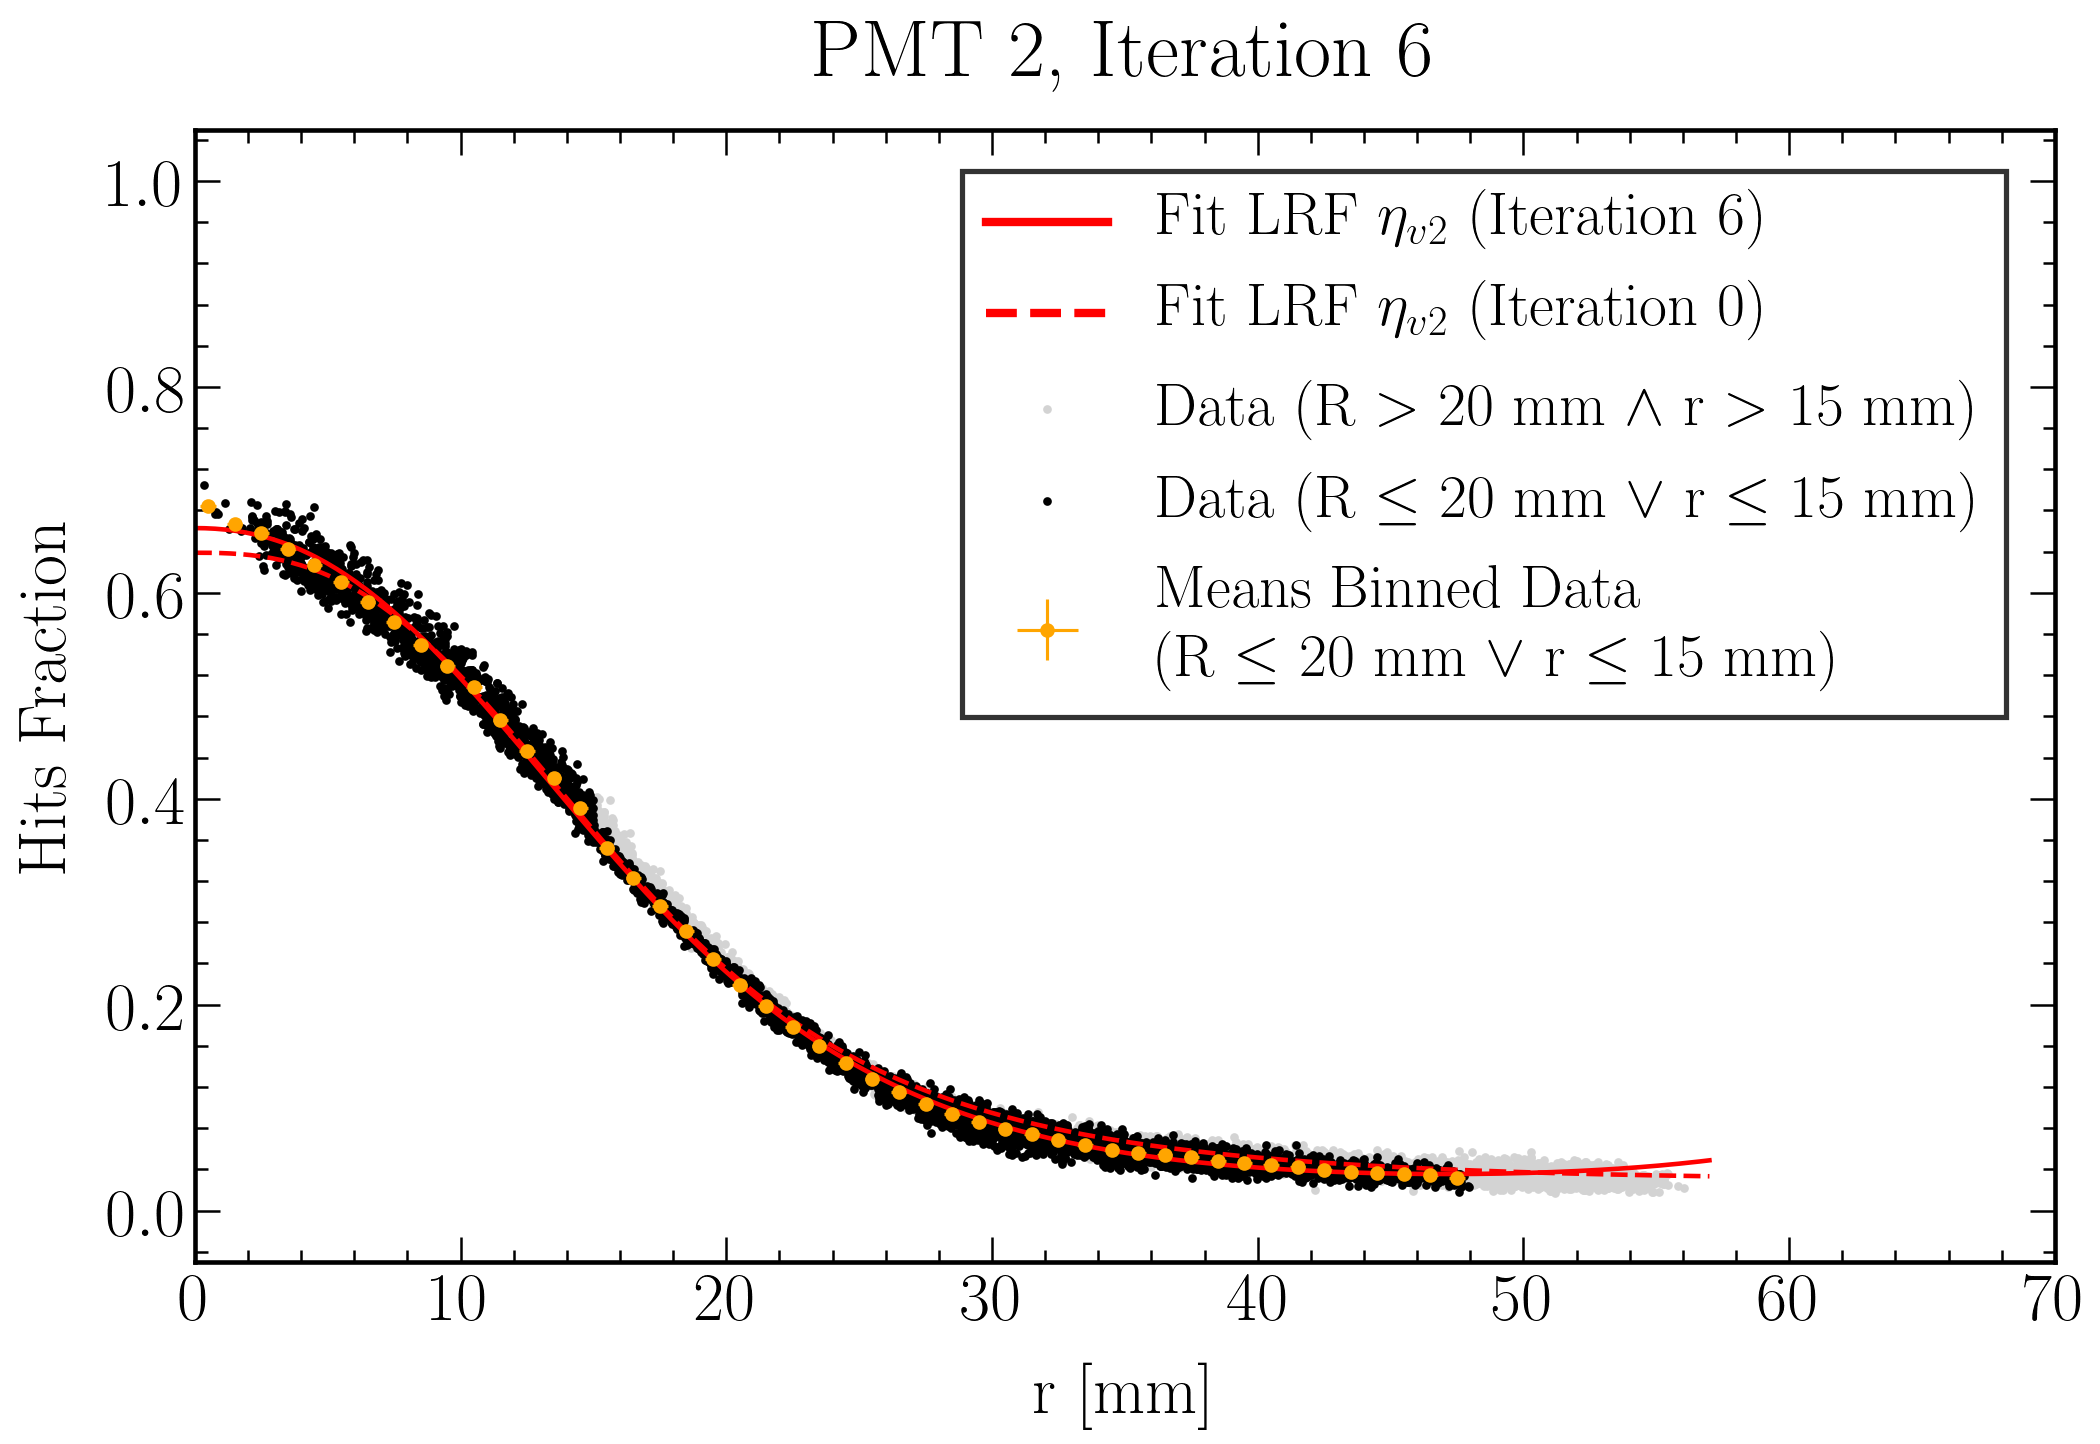

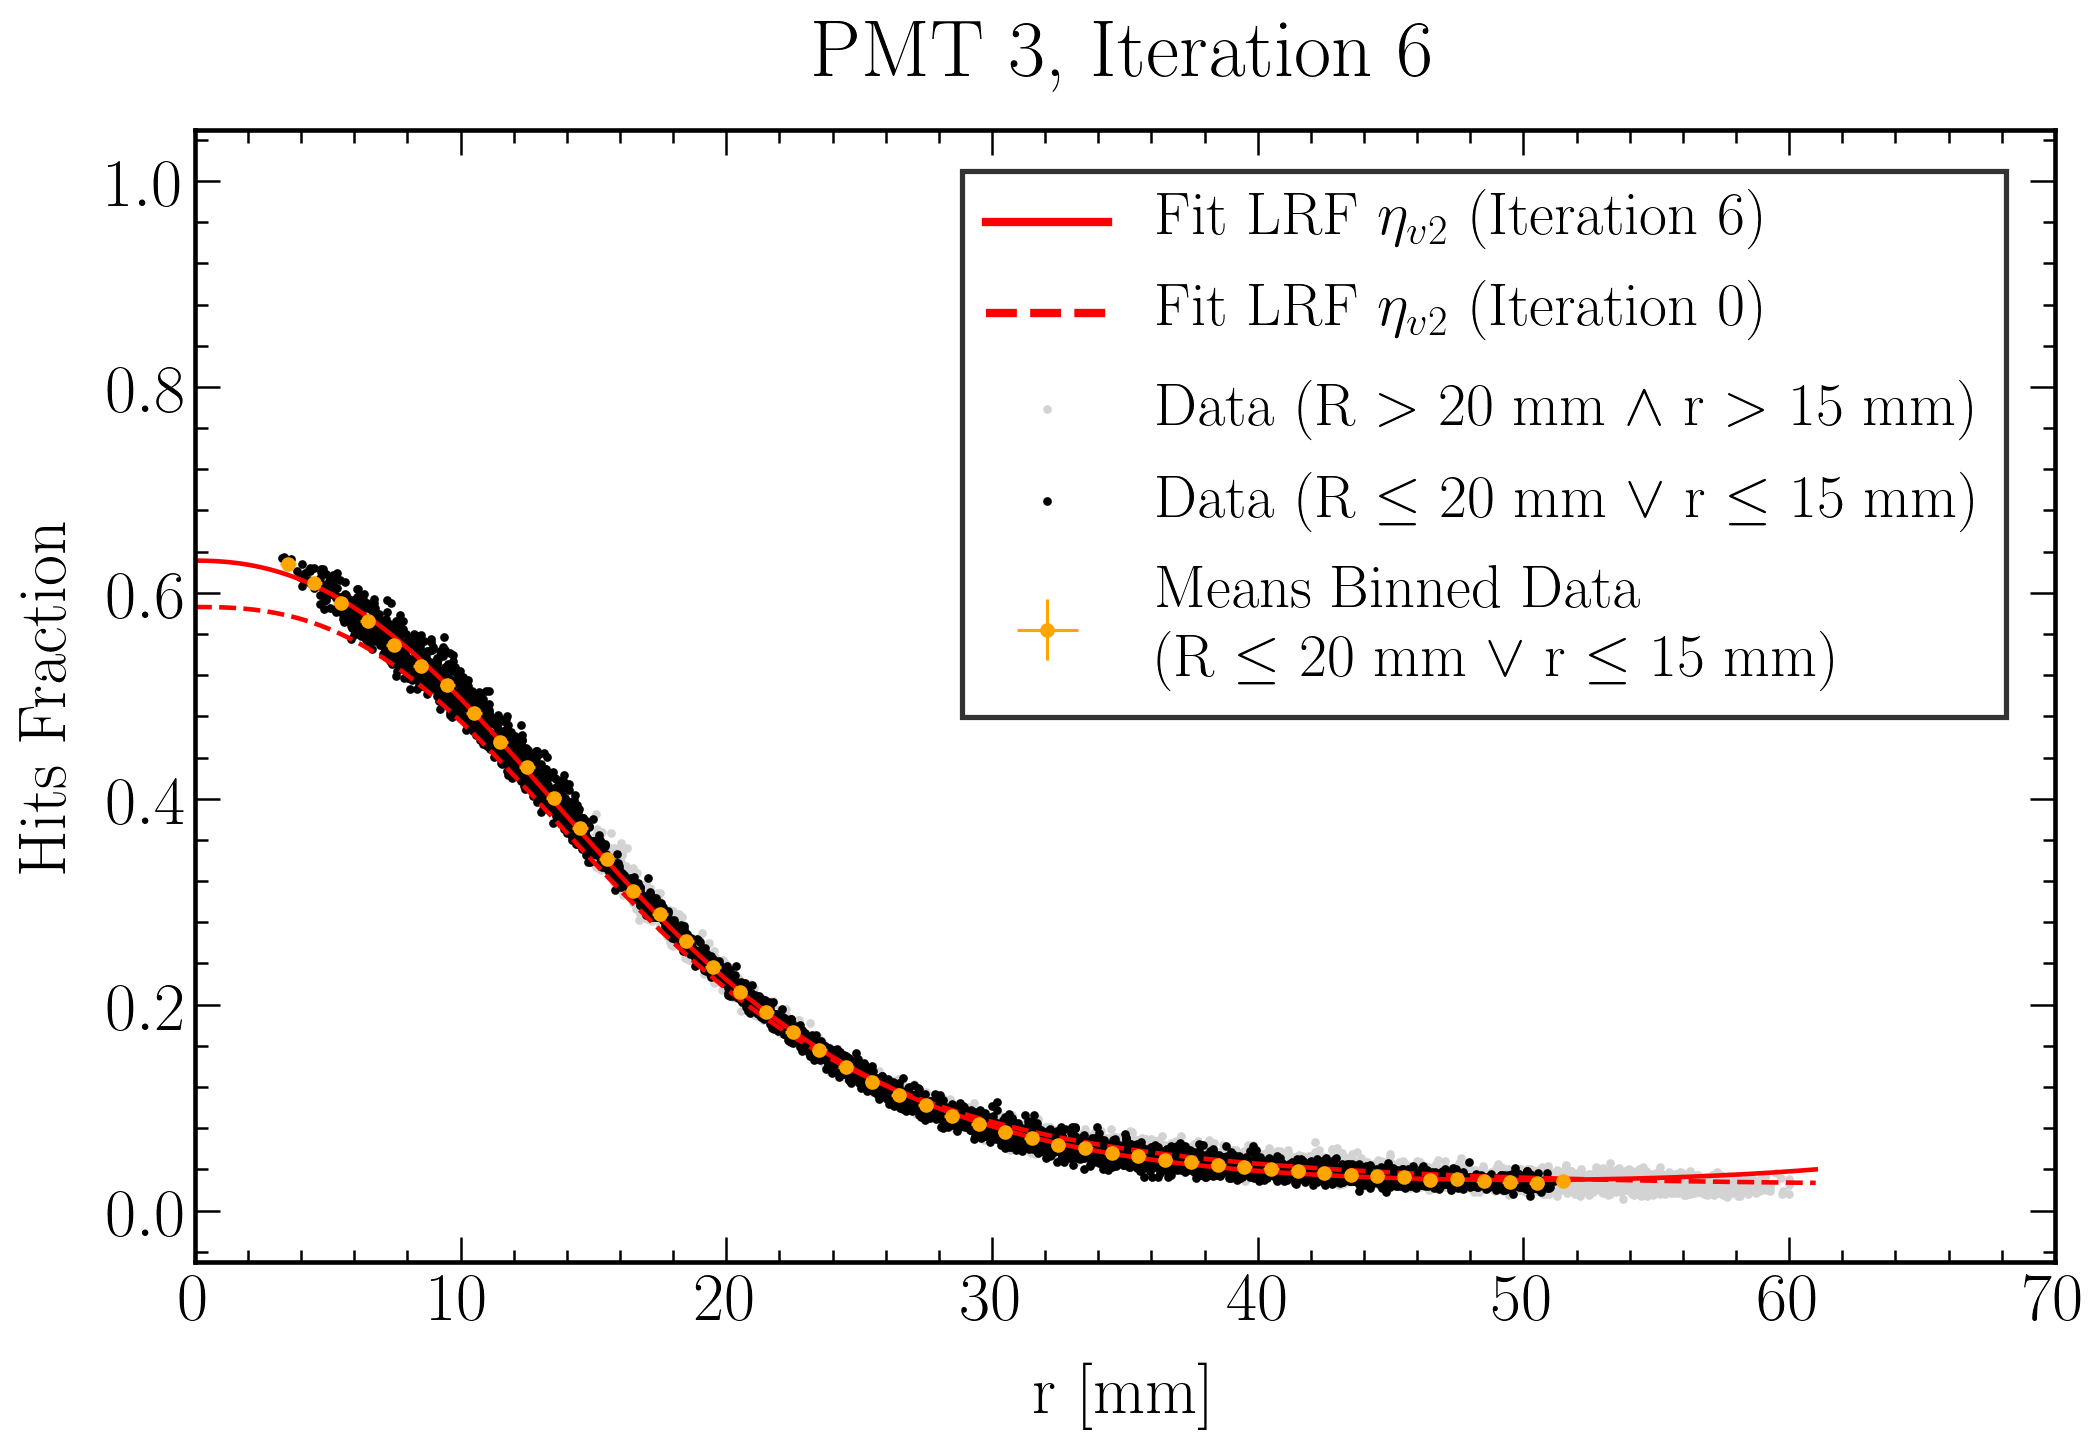

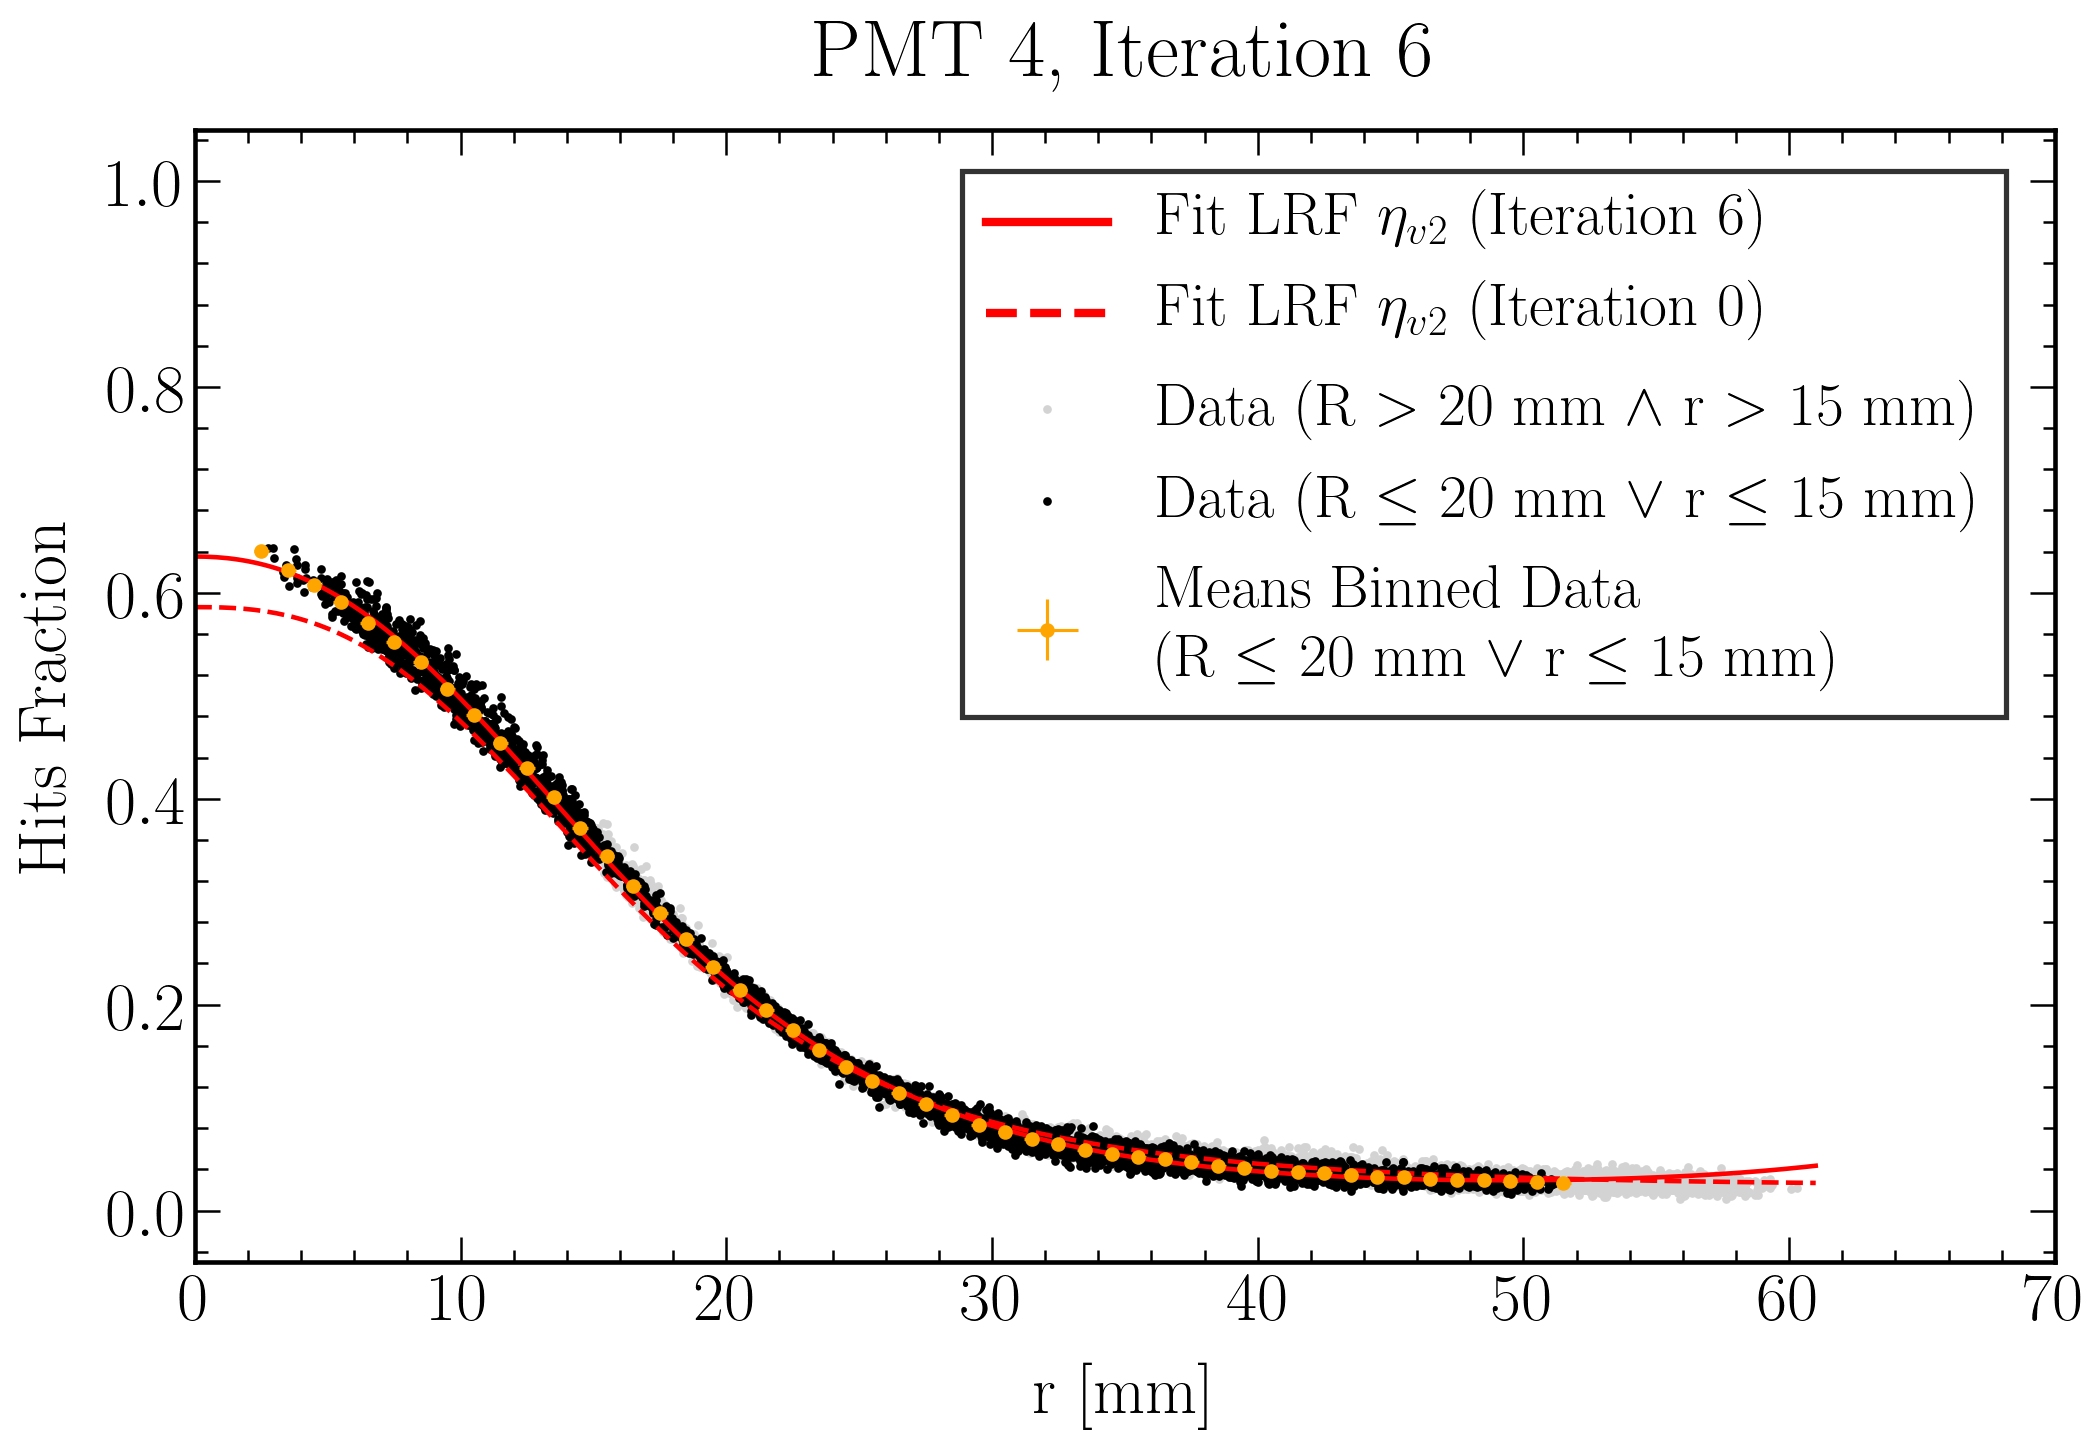

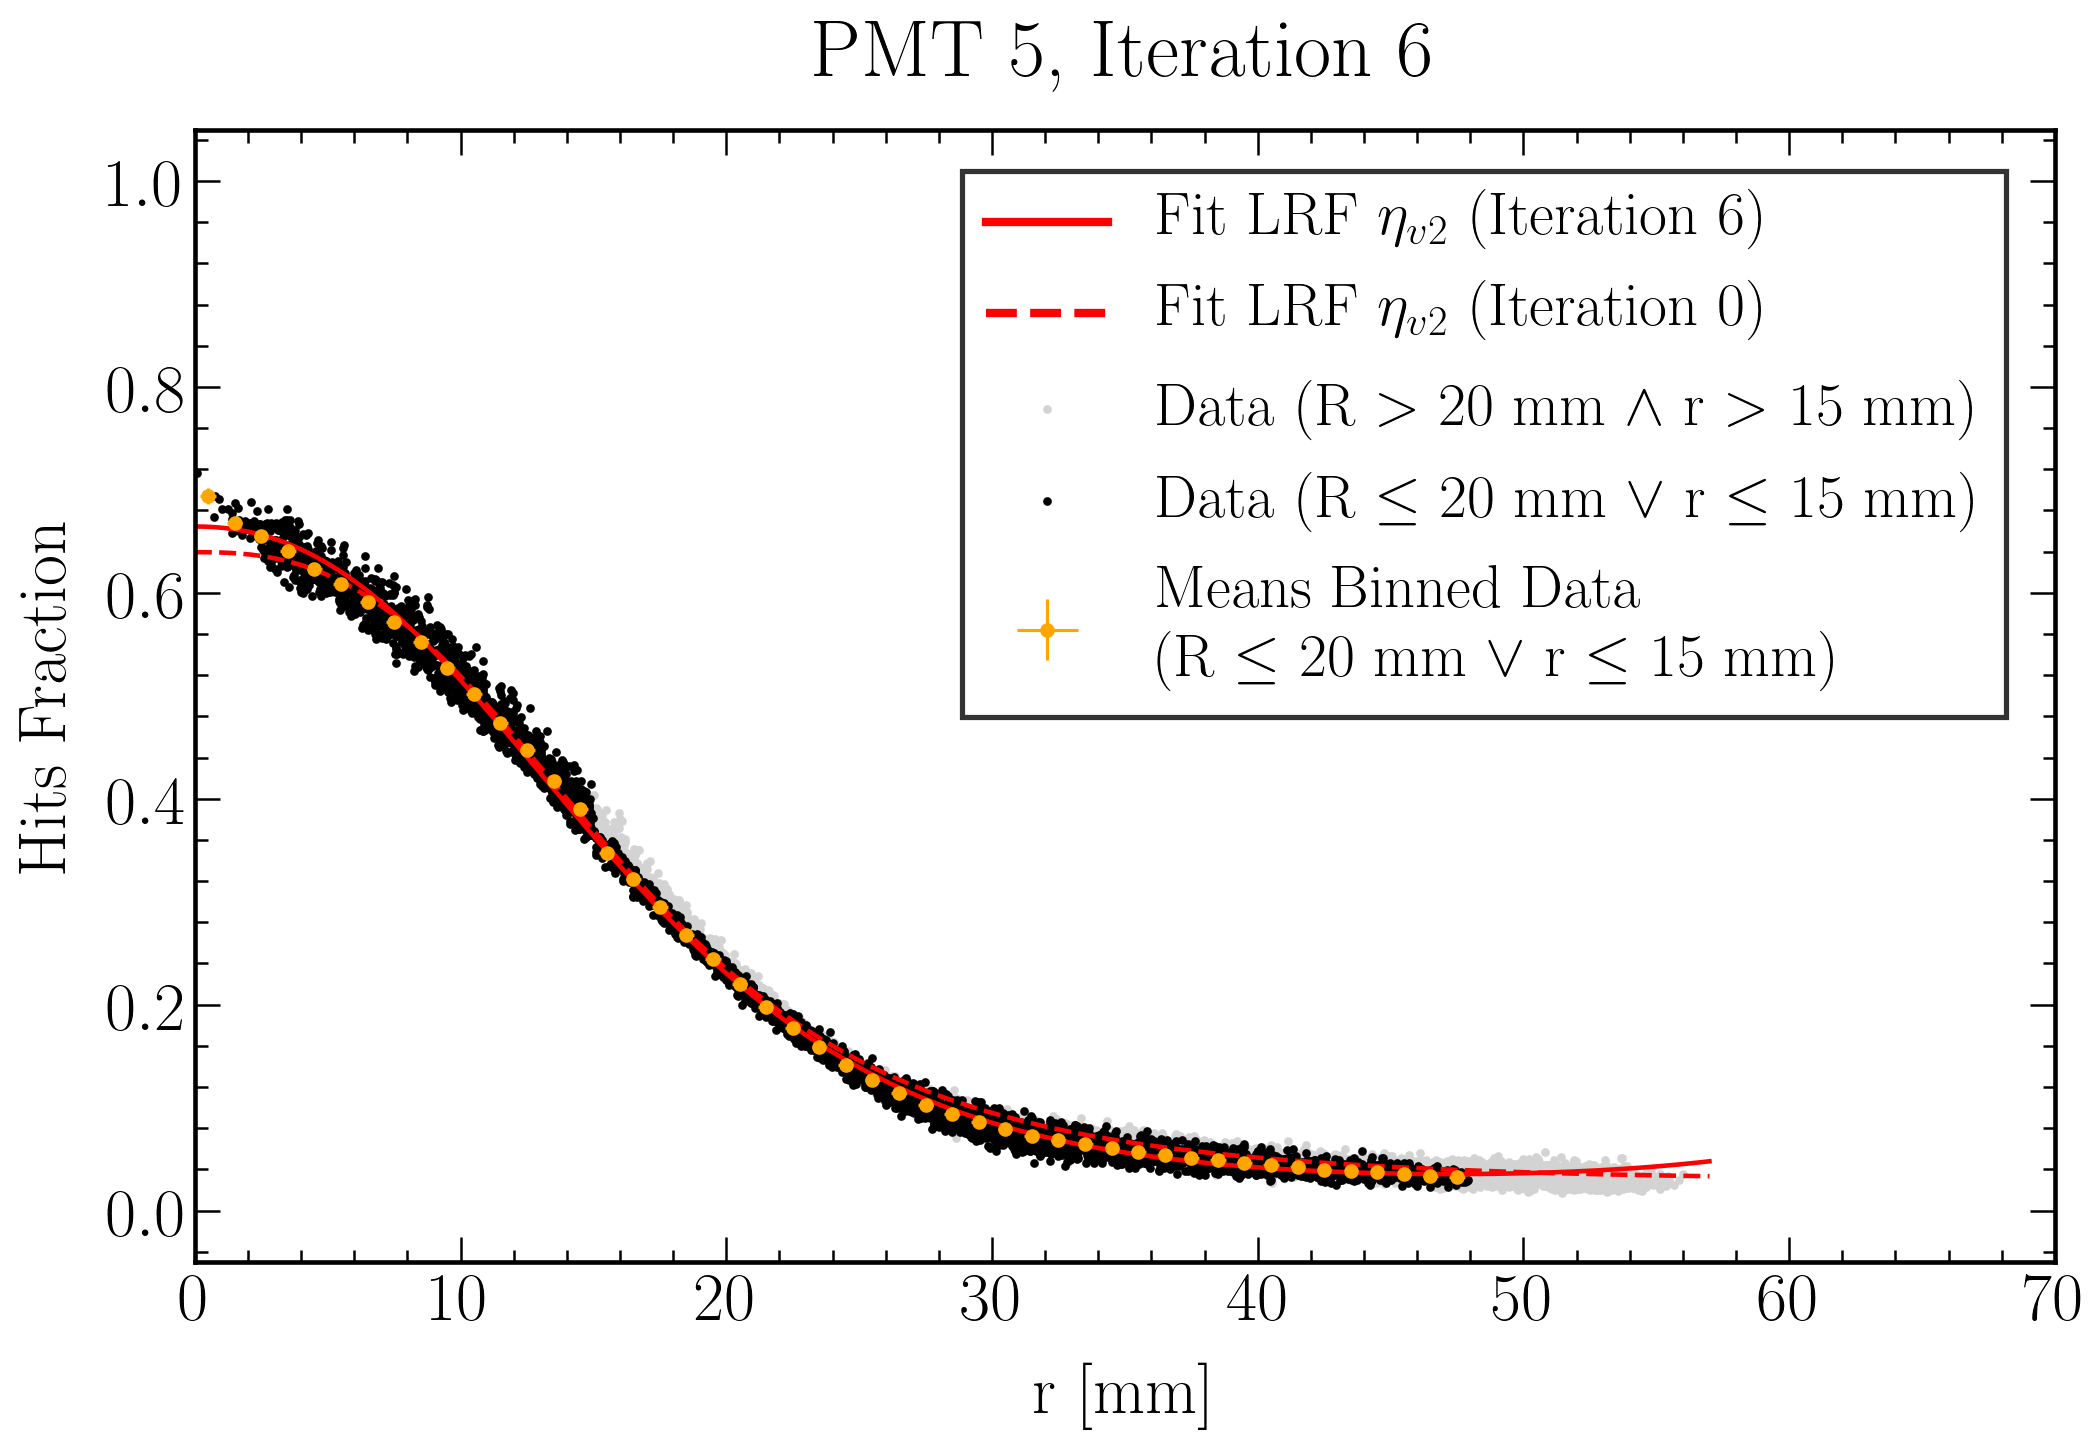

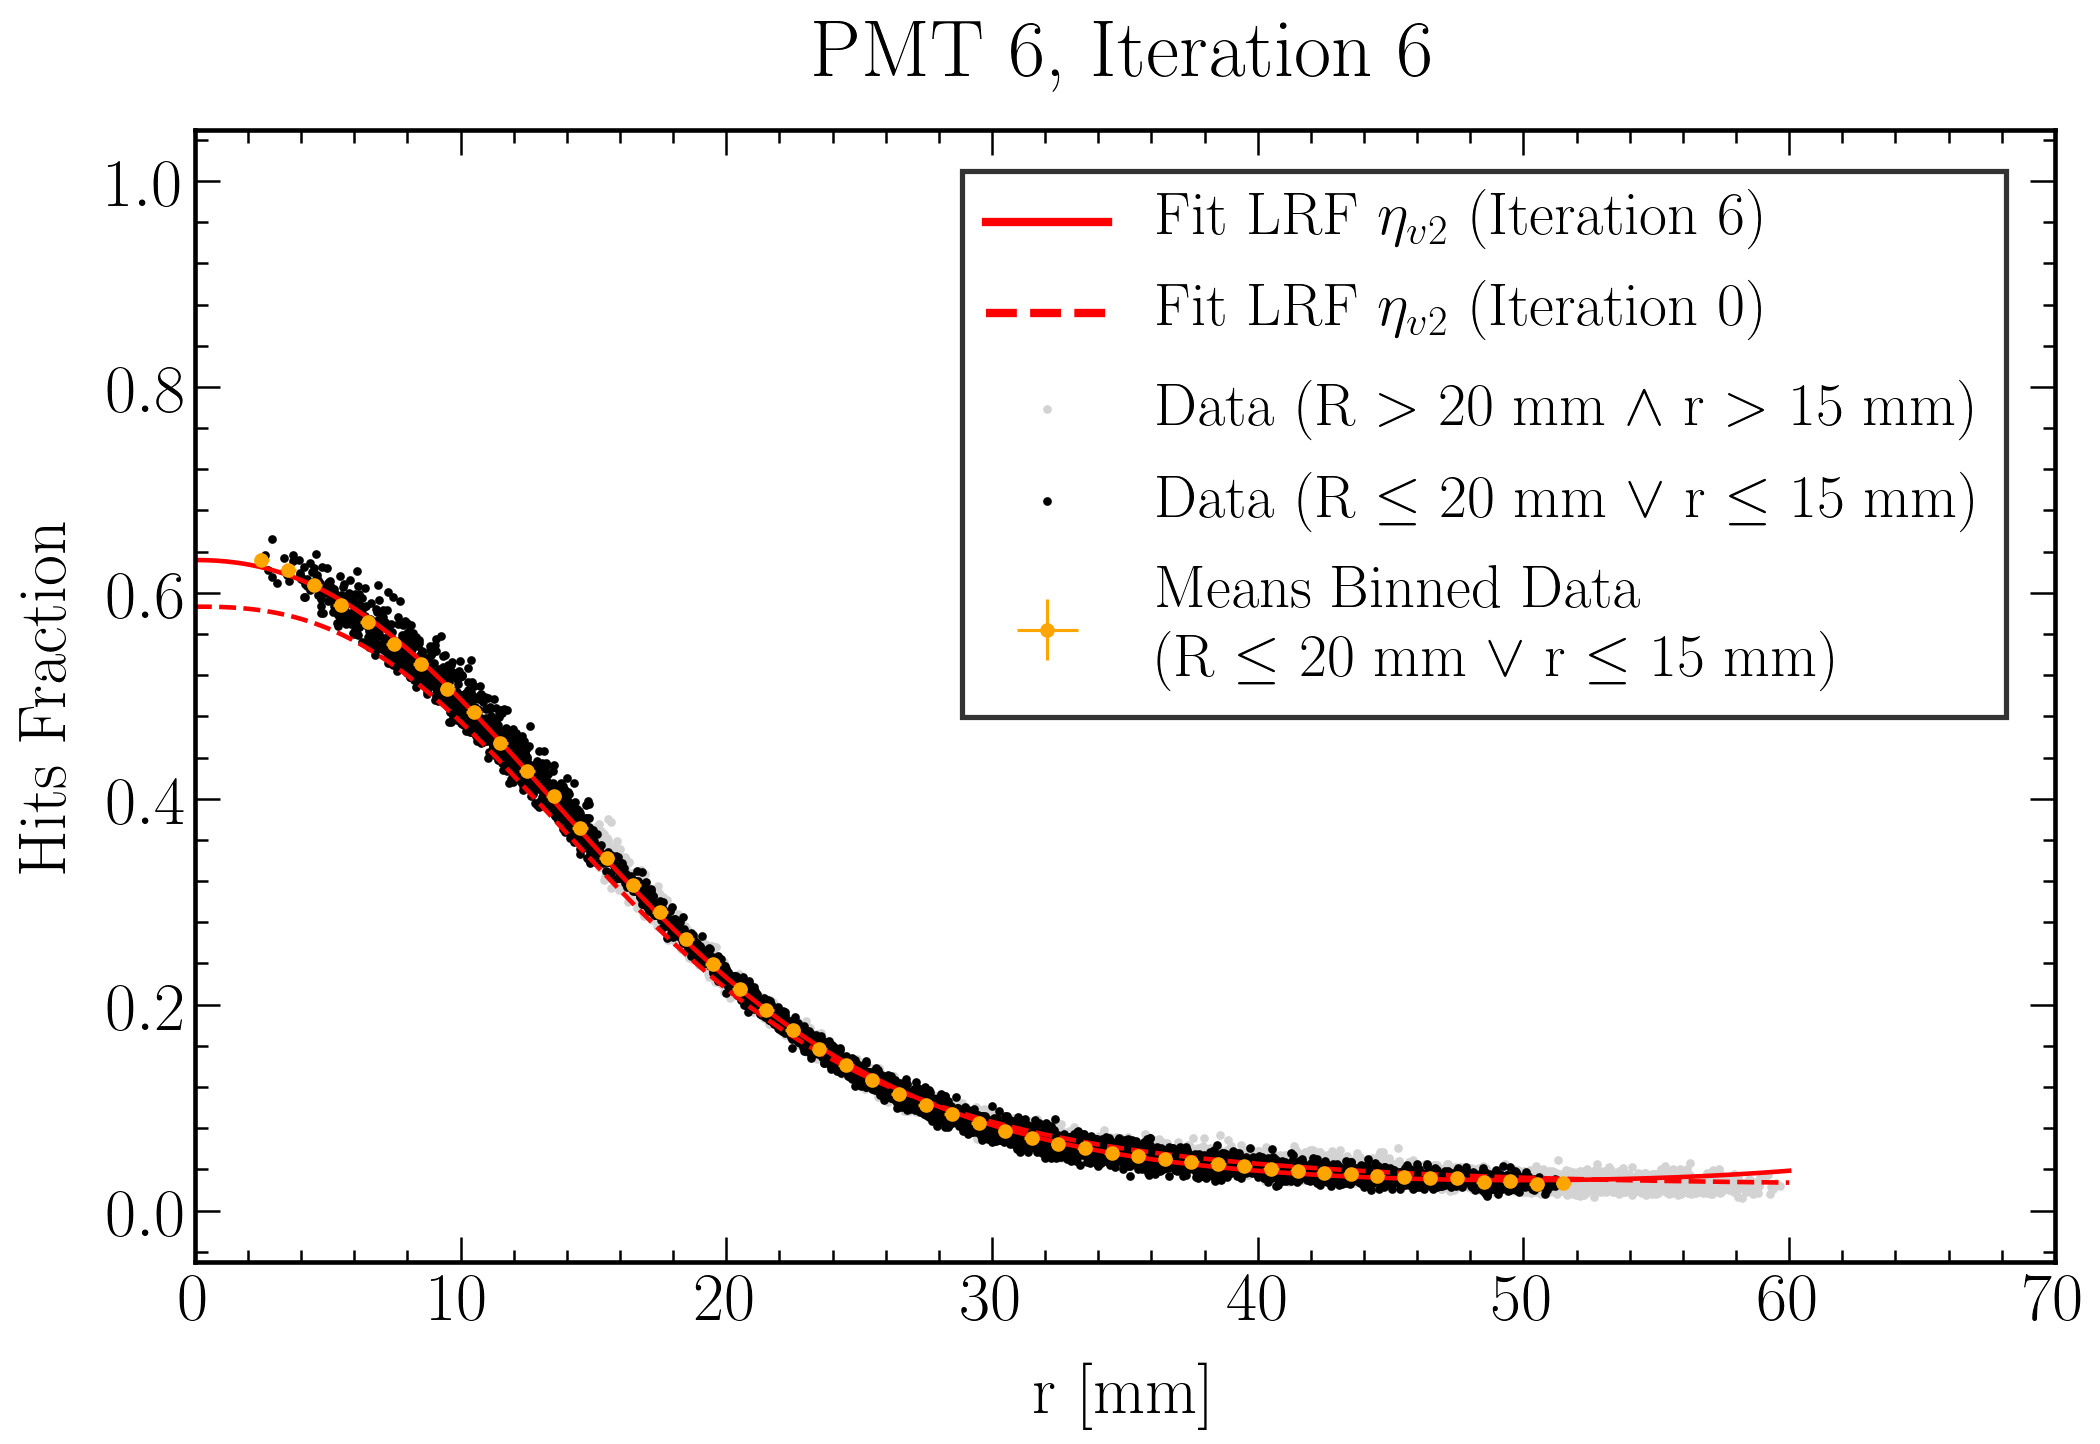

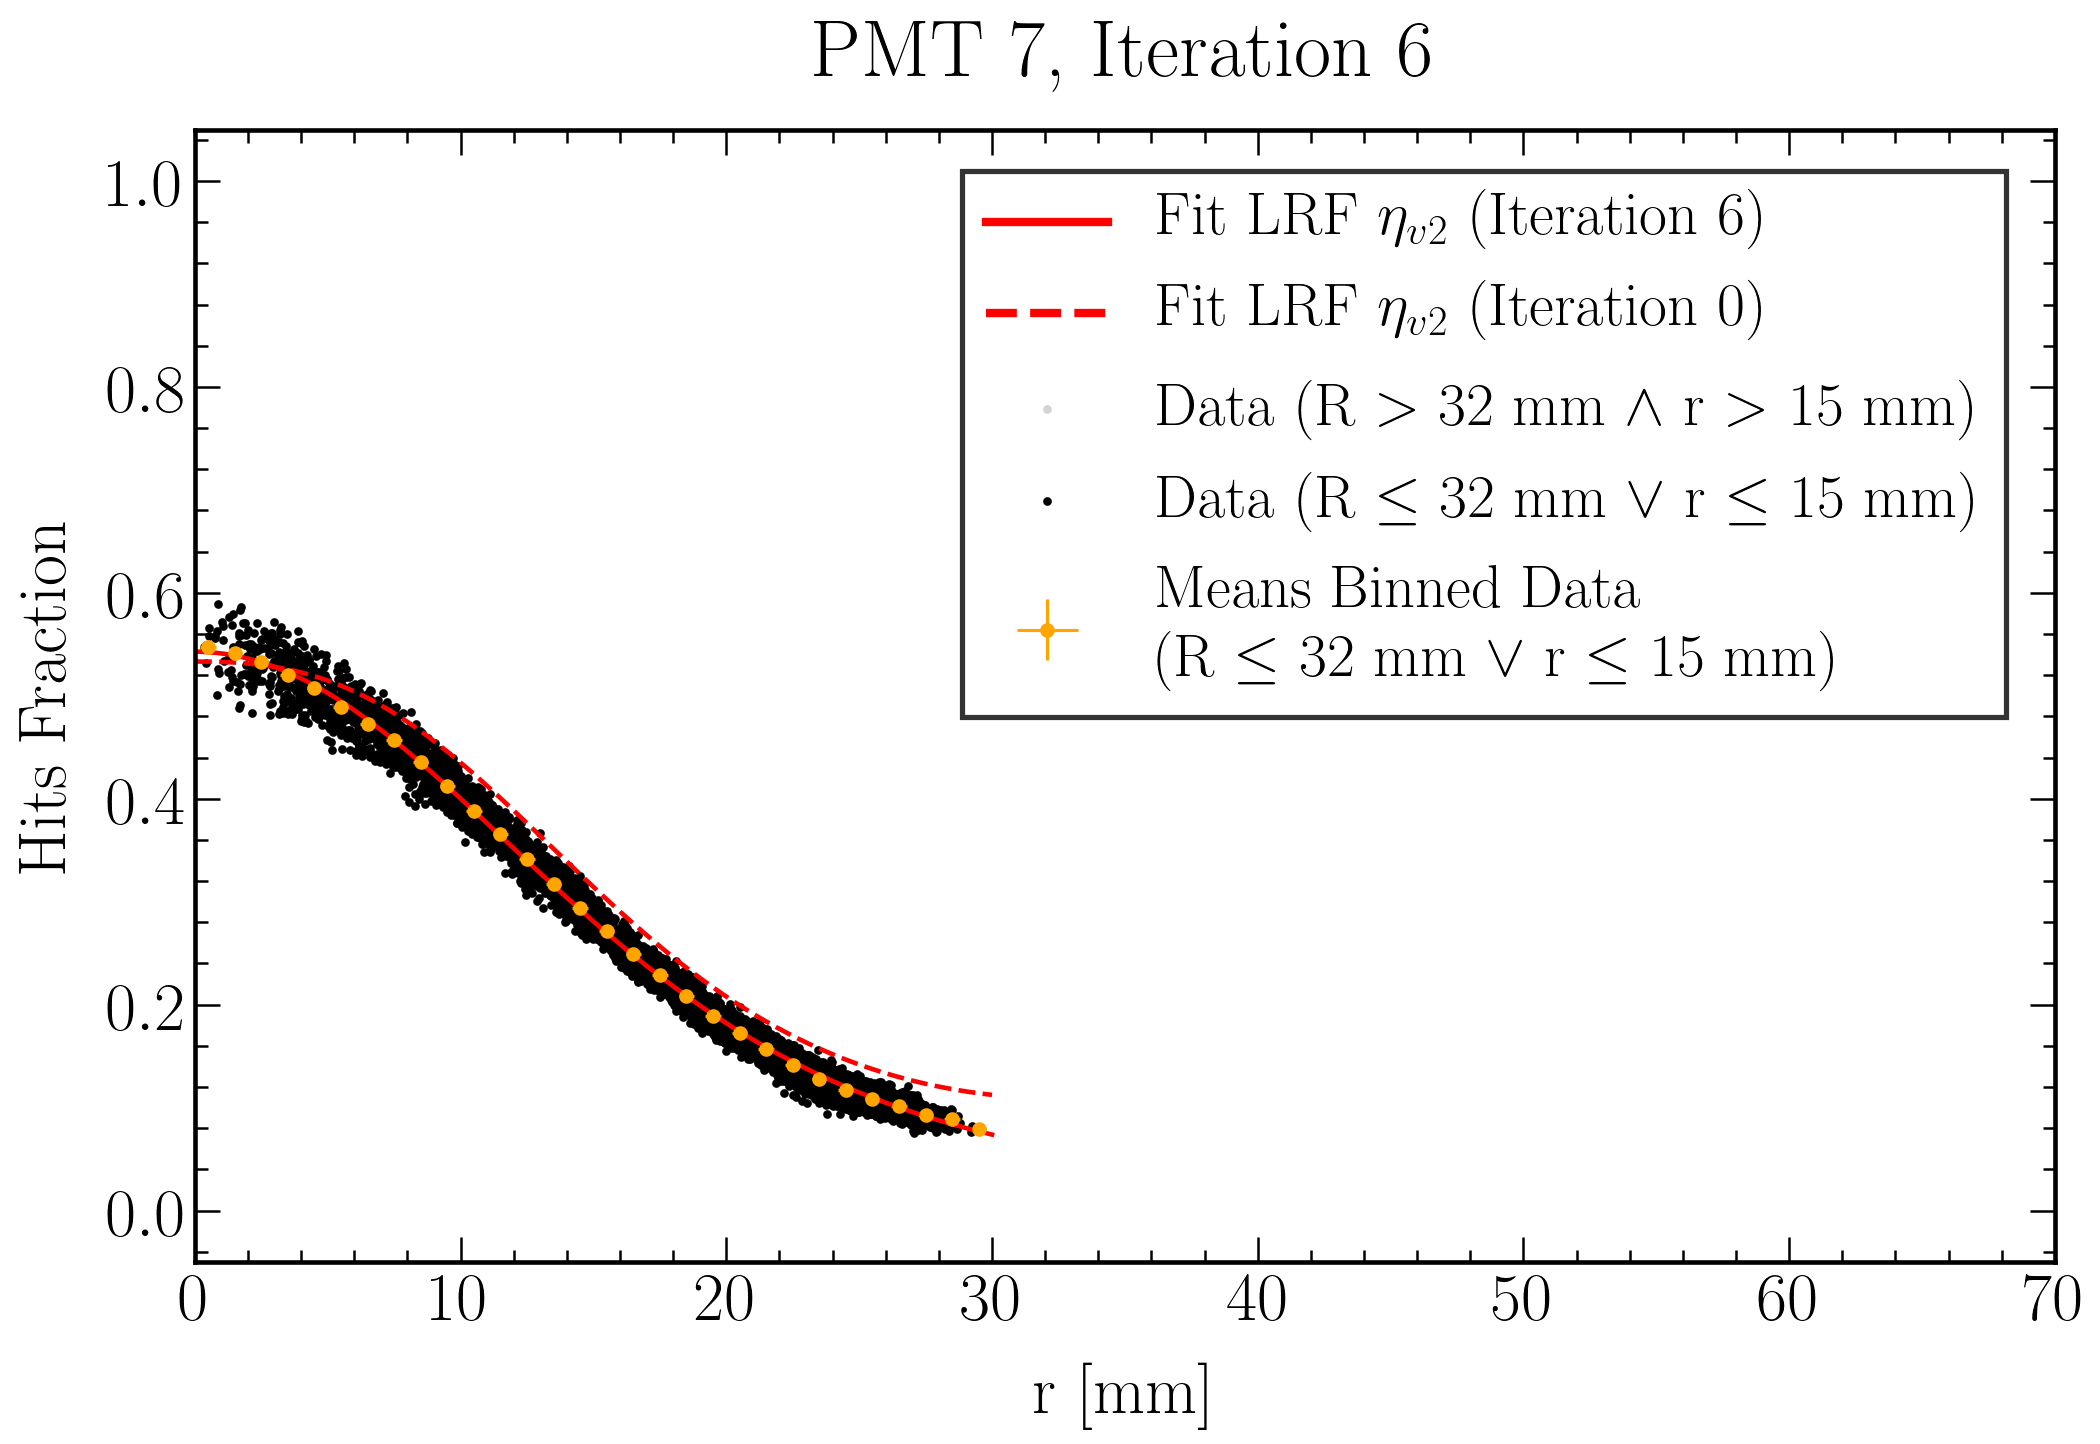

In [47]:
## Calculate radial positions
R_pos_list = np.hypot(Iterative_Reconstruciton.at[iteration, 'x_pos'], Iterative_Reconstruciton.at[iteration, 'y_pos'])
r_pos_list = np.array([np.hypot(Iterative_Reconstruciton.at[iteration, 'x_pos'] - PMT_positions['PMT_position_x'][i], Iterative_Reconstruciton.at[iteration, 'y_pos'] - PMT_positions['PMT_position_y'][i]) for i in range(1,8)])

## Create radial plots and perform fits
fit_parameters = np.array([None]*7)
r_pos_binned = np.array([None]*7)
HF_binned = np.array([None]*7)

for i in range(1,8):
    
    if i == 7:
        rfiducial = Iterative_Reconstruciton.at[iteration, 'rfiducial_central']
        rfiducial_under = Iterative_Reconstruciton.at[iteration, 'rfiducial_under']
    else:
        rfiducial = Iterative_Reconstruciton.at[iteration, 'rfiducial']
        rfiducial_under = Iterative_Reconstruciton.at[iteration, 'rfiducial_under']
    HF = HF_list[i-1]
    R = R_pos_list
    r = r_pos_list[i-1]
    
    ## Fiducialise
    r_fiducial = r[(R <= rfiducial) | (r <= rfiducial_under)]
    HF_fiducial = HF[(R <= rfiducial) | (r <= rfiducial_under)]
    r_fiducial_complementary = r[(R > rfiducial) & (r > rfiducial_under)]
    HF_fiducial_complementary = HF[(R > rfiducial) & (r > rfiducial_under)]
    
    ## Bin to account for different arc lengths
    statistic, bin_edges, binnumber = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='mean', bins=(70), range=(0,70))
    bin_center = (bin_edges[:-1]+bin_edges[1:])/2
    statistic_isnan = statistic[~np.isnan(statistic)]
    bin_center_isnan = bin_center[~np.isnan(statistic)]
    
    statistic_std, _, _ = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='std', bins=(70), range=(0,70))
    statistic_std_isnan = statistic_std[~np.isnan(statistic)]
    
    statistic_count, _, _ = stats.binned_statistic(r_fiducial, HF_fiducial, statistic='count', bins=(70), range=(0,70))
    statistic_count_isnan = statistic_count[~np.isnan(statistic)]

    r_pos_binned[i-1] = bin_center_isnan
    HF_binned[i-1] = statistic_isnan
    
    '''## Fit
    if modelstring == 'eta_v2':
        bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
        popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan, bounds = bnds)
    else:
        popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan)
    fit_parameters[i-1] = popt
    '''
    
    try: 
        if (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)<0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1<1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan, bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan, statistic_isnan)
            fit_parameters[i-1] = popt
        elif (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)>=0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1<1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[1:], statistic_isnan[1:], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[1:], statistic_isnan[1:])
            fit_parameters[i-1] = popt
        elif (np.abs((statistic_isnan[0]/statistic_isnan[1])-1)<0.1) & ((statistic_isnan[-2]/statistic_isnan[-1])-1>=1):   
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[:-1], statistic_isnan[:-1], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[:-1], statistic_isnan[:-1])
            fit_parameters[i-1] = popt
        else:
            if modelstring == 'eta_v2':
                bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
                popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1], bounds = bnds)
            else:
                popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1])
            fit_parameters[i-1] = popt
    except:
        if modelstring == 'eta_v2':
            bnds=((0, 0, -np.inf, 0, 0), (np.inf, np.inf, 0, np.inf, np.inf))
            popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1], bounds = bnds)
        else:
            popt, pcov = curve_fit(model, bin_center_isnan[1:-1], statistic_isnan[1:-1])
        fit_parameters[i-1] = popt
    
    ##################################################################################################
    #### Plot

    fig=plt.figure(figsize=(16, 10), dpi=150)

    ## Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    ## Labels
    label_size = 32.5 #25
    label_pad = 13 #10
    title_size = 39 #30
    title_pad = 26 #20

    ## Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    ## Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    ## Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    ## Grid
    #plt.grid(True)

    if rfiducial_under > 0:
        lbl = "Data (R $>$ "+str(rfiducial)+" mm $\land$ r $>$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Data (R $>$ "+str(rfiducial)+" mm)"
    plt.scatter(r_fiducial_complementary, HF_fiducial_complementary, s=10, color = 'lightgray', label = lbl)
    if rfiducial_under > 0:
        lbl = "Data (R $\leq$ "+str(rfiducial)+" mm $\lor$ r $\leq$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Data (R $\leq$ "+str(rfiducial)+" mm)"
    plt.scatter(r_fiducial, HF_fiducial, s=10, color = 'black', label = lbl)
    if rfiducial_under > 0:
        lbl = "Means Binned Data\n(R $\leq$ "+str(rfiducial)+" mm $\lor$ r $\leq$ "+str(rfiducial_under)+" mm)"
    else:
        lbl = "Means Binned Data\n(R $\leq$ "+str(rfiducial)+" mm)"
    plt.errorbar(bin_center_isnan, statistic_isnan, 
                 yerr=statistic_std_isnan/np.sqrt(statistic_count_isnan), 
                 xerr = (70/70)/np.sqrt(12), fmt='o', color = 'orange', 
                 label = lbl)
    
    if int(modelstring[-1]) == 1:
        label = 'Fit LRF $\eta_{v1}$'
    elif int(modelstring[-1]) == 2:
        label = 'Fit LRF $\eta_{v2}$'
    elif int(modelstring[-1]) == 3:
        label = 'Fit LRF $\eta_{v3}$'
    elif int(modelstring[-1]) == 4:
        label = 'Fit LRF $\eta_{v4}$'
    else:
        label = 'Fit LRF'
    plt.plot(np.linspace(0, math.ceil(np.max(r)), 300), model(np.linspace(0, math.ceil(np.max(r)), 300), *eval("fit_parameters")[i-1]), color = 'r', linewidth = 2.2, label = label+' (Iteration '+str(eval(iteration+'+1'))+')')
    plt.plot(np.linspace(0, math.ceil(np.max(r)), 300), model(np.linspace(0, math.ceil(np.max(r)), 300), *np.array(Iterative_Reconstruciton["fit_parameter"]["0"].tolist())[i-1]), color = 'r', linewidth = 2.2, label = label+' (Iteration 0)', linestyle = 'dashed')
    
    plt.xlim(0.,35.*2)
    plt.ylim(-0.05, 1.05)
    
    # Axes Label 
    plt.xlabel('r [mm]', fontsize = label_size, labelpad = label_pad)
    plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
    plt.title('PMT '+str(i)+', Iteration '+str(eval(iteration+'+1')), fontsize = title_size, pad = title_pad)
    
    # Legend
    leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    for line in leg.get_lines(): # enumerated
        line.set_linewidth(4)
    leg.get_frame().set_linewidth(2.5)

    fig.savefig(filenameprefix+"_Iterative_Reconstruciton_iteration_"+str(eval(iteration+'+1'))+"_PMT_"+str(i)+".png")
    plt.show()
    #################################################################################################

    ## Write to dataframe
    Iterative_Reconstruciton.at[iteration, 'r_pos_binned'] = r_pos_binned
    Iterative_Reconstruciton.at[iteration, 'HF_binned'] = HF_binned
if eval(iteration+'+1') <= iterations:
    Iterative_Reconstruciton.at[str(eval(iteration+'+1')), 'fit_parameter'] = fit_parameters
Iterative_Reconstruciton.at[iteration, 'fit_parameter_end'] = fit_parameters

In [48]:
Iterative_Reconstruciton.head(eval(iteration+'+1'))

rfiducial  rfiducial_under  rfiducial_central  \
0         20               15                 32   
1         20               15                 32   
2         20               15                 32   
3         20               15                 32   
4         20               15                 32   
5         20               15                 32   

                                       fit_parameter  \
0  [[0.5862075, 30.03753042, -0.34682365, 4.18897...   
1  [[0.6017073963620089, 38.7302590431945, -4.027...   
2  [[0.6183459043835552, 43.129166330359276, -6.3...   
3  [[0.627798381471581, 48.34741093020025, -10.55...   
4  [[0.6345135617096274, 51.75905632867351, -13.8...   
5  [[0.6349043341807443, 51.02000844229367, -13.2...   

                                               x_pos  \
0  [17.618000307344, 30.552376361769564, -15.4647...   
1  [17.3013291457405, 30.455956351607558, -15.082...   
2  [16.93612236692497, 30.154250957850888, -14.76...   
3  [16.615216386266592, 29.431376473767866, -14.5...   
4  [16.366924245315598, 28.182165820505343, -14.3...   
5  [16.142382994897247, 27.392299857756285, -14.1...   

                                               y_pos  \
0  [16.91237920021913, -2.033241012730516, 20.361...   
1  [16.582137440360153, -2.0807944665584777, 19.6...   
2  [16.329175822028212, -1.996003322743022, 19.31...   
3  [16.096415515672177, -1.7864947948697543, 19.1...   
4  [15.900474259618305, -1.5392371168293755, 19.0...   
5  [15.741791383200976, -1.4590623396973303, 18.8...   

                                        r_pos_binned  \
0  [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5,...   
1  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
2  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
3  [[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5,...   
4  [[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5...   
5  [[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5...   

                                           HF_binned  \
0  [[0.6149924051067908, 0.6068165928205498, 0.60...   
1  [[0.6306566897637992, 0.6148077704403064, 0.59...   
2  [[0.6381987577639752, 0.6234712766152656, 0.61...   
3  [[0.6381987577639752, 0.6338842975206612, 0.61...   
4  [[0.6381987577639752, 0.6224500911273406, 0.60...   
5  [[0.6381987577639752, 0.6237087522129565, 0.61...   

                                   fit_parameter_end  
0  [[0.6017073963620089, 38.7302590431945, -4.027...  
1  [[0.6183459043835552, 43.129166330359276, -6.3...  
2  [[0.627798381471581, 48.34741093020025, -10.55...  
3  [[0.6345135617096274, 51.75905632867351, -13.8...  
4  [[0.6349043341807443, 51.02000844229367, -13.2...  
5  [[0.6371275778677232, 51.91573754483526, -14.5...